#### Music Genre Classification - Modelos Clássicos
##### Notebook 1 - Dedicado a maior parte dos testes realizadas nesse trabalho
##### Notebook 2 - Dedicado a realizar testes com a MLP (utilizando tensorflow), extrair Shap Values, Data Augmentation, avaliar os resultados para as features mais importantes, dentre outros testes
- 1. Leitura dos dados, retirar informações que não serão utilizadas (length, filename);
- 2. Separação dos conjuntos (20% teste, 20% validação e 60% treino); 
- 3. Modelos baseline + Otimização dos hiperparâmetros
- 4. Corrigindo a separação dos dados (evitando vazamento)
- 5. Teste com validação cruzada
- 6. Extração manual de features
- 7. Adição de Features
- 8. Variando MFCCs e outros testes
- 9. Ensemble + Matriz de Confusão


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.ensemble import GradientBoostingClassifier
import librosa
import os
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

In [23]:
df = df.drop(['length', 'filename'], axis=1)

In [24]:
train_val, test = train_test_split(df, stratify=df['label'], test_size=1/5, random_state=42)
train, val = train_test_split(train_val, stratify=train_val['label'], test_size=1/4, random_state=42)

X_train_val = train_val.drop(columns=['label']); y_tv = train_val['label']
X_train = train.drop(columns=['label']); X_val = val.drop(columns=['label'])
y_train = train['label']; y_val = val['label']
X_test= test.drop(columns=['label']); y_test = test['label']
print((X_train.shape));
print((X_test.shape)); 
print((X_val.shape)); 
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(5994, 57)
(1998, 57)
(1998, 57)
(5994,)
(1998,)
(1998,)


Obs: com essa divisão, estão sendo vazados dados do conjunto de treino para o de teste, considerando que agora temos dez trechos distintos de uma mesma música. Será necessário reavaliar a forma como dividir esses conjuntos.

In [22]:
def grid_search(model, param_grid, X_train, y_train, X_val, y_val):
    val_index = [-1]*len(X_train) + [0]*len(X_val)
    gs = GridSearchCV(model, param_grid, refit=True, cv=PredefinedSplit(val_index), n_jobs = -1,scoring='accuracy')
    gs.fit(np.r_[X_train, X_val], np.r_[y_train, y_val])
    return gs

In [26]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_tv_scaled = scaler.transform(X_train_val)

### Treinando os modelos baseline e realizando otimizações dos hiperparâmetros:

#### Logistic Regression:

In [15]:
model = make_pipeline(LogisticRegression(max_iter=500, solver='newton-cg', multi_class = 'multinomial', C=1));
model.fit(X_train, y_train);

print('Logistic Regression: baseline')
print(f'Train balanced accuracy: {accuracy_score(y_train, model.predict(X_train)):.1%}')
print(f'Validation balanced accuracy: {accuracy_score(y_val, model.predict(X_val)):.1%}')

KeyboardInterrupt: 

- Aplicando StandardScaler(), e verificando ganho em desempenho: 

In [51]:
model_lbase = make_pipeline(StandardScaler(),LogisticRegression(max_iter=10000, solver='newton-cg', multi_class = 'multinomial'));
model_lbase.fit(X_train, y_train);

print('Logistic Regression: baseline')
print(f'Train accuracy: {accuracy_score(y_train, model_lbase.predict(X_train)):.1%}')
print(f'Validation accuracy: {accuracy_score(y_val, model_lbase.predict(X_val)):.1%}')
pickle.dump(model_lbase, open('model_lbase.sav', 'wb'))

Logistic Regression: baseline
Train accuracy: 74.6%
Validation accuracy: 71.6%


In [27]:
param_grid = dict()
param_grid['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1,0.5, 1,2, 5, 10,15,30,50, 100]

model = LogisticRegression(max_iter=10000, solver='newton-cg', multi_class = 'multinomial')

gs_l = grid_search(model, param_grid, X_train_scaled, y_train,X_val_scaled,y_val)
print('best_score:', gs_l.best_score_)
print('best_params:', gs_l.best_params_)

best_score: 0.7182182182182182
best_params: {'C': 100}


In [30]:
model_lop = make_pipeline(StandardScaler(),LogisticRegression(**gs_l.best_params_, max_iter = 10000));
model_lop.fit(X_train_scaled, y_train);

print('Logistic Regression: optimzed')

print(f'Val accuracy: {accuracy_score(y_val, model_lop.predict(X_val_scaled)):.1%}')
print(f'Test accuracy: {accuracy_score(y_test, model_lop.predict(X_test_scaled)):.1%}')
model_lop.fit(X_tv_scaled, y_tv);
print(f'Test (refit) accuracy: {accuracy_score(y_test, model_lop.predict(X_test_scaled)):.1%}')
pickle.dump(model_lop, open('model_lop.sav', 'wb'))

Logistic Regression: optimzed
Val accuracy: 71.8%
Test accuracy: 71.9%
Test (refit) accuracy: 72.5%


#### SVM: 

In [53]:
model = make_pipeline(SVC(kernel='rbf', max_iter = 10000,random_state=0));
model.fit(X_train, y_train);

print('Baseline: SVM')
print(f'Train accuracy: {accuracy_score(y_train, model.predict(X_train)):.1%}')
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val)):.1%}')
pickle.dump(model, open('model_svmb.sav', 'wb'))

Baseline: SVM


KeyboardInterrupt: 

In [54]:
model = make_pipeline(StandardScaler(),SVC(kernel='rbf', max_iter = 10000,random_state=0));
model.fit(X_train, y_train);

print('Baseline: SVM')
print(f'Train accuracy: {accuracy_score(y_train, model.predict(X_train)):.1%}')
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val)):.1%}')

Baseline: SVM
Train accuracy: 91.3%
Validation accuracy: 84.2%


In [29]:
param_grid = {'C':     10.0**np.arange(-3, 5.01, 1), 
              'gamma': 10.0**np.arange(-5, 3.01, 1)}
model = SVC(kernel='rbf', max_iter = 10000,random_state=0);
gs_svm = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_svm.best_score_)
print('best_params:', gs_svm.best_params_)


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Con

best_score: 0.8943943943943944
best_params: {'C': 10.0, 'gamma': 0.01}


In [31]:
model = SVC(random_state=0,max_iter=10000, **gs_svm.best_params_);
model.fit(X_train_scaled, y_train);

print('Optimized: SVM')
print(f'Val accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled, y_tv);
print(f'Test refited accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
pickle.dump(model, open('model_svmop.sav', 'wb'))

Optimized: SVM
Val accuracy: 89.4%
Test accuracy: 87.5%
Test refited accuracy: 89.1%


#### K-NN:

In [65]:
model = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors = 3))
model.fit(X_train, y_train)

print('Baseline: K-Nearest Neighbors')
print(f'Train accuracy: {accuracy_score(y_train, model.predict(X_train)):.1%}')
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val)):.1%}')

Baseline: K-Nearest Neighbors
Train accuracy: 95.0%
Validation accuracy: 87.8%


In [32]:
model = KNeighborsClassifier()
param_grid = { 'n_neighbors' : [3,5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

gs_knn = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_knn.best_score_)
print('best_params:', gs_knn.best_params_)

best_score: 0.9159159159159159
best_params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


In [33]:
model = KNeighborsClassifier(**gs_knn.best_params_)
model.fit(X_train_scaled,y_train)
print('Optimized: K-Nearest Neighbors')
print(f'Val accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled,y_tv)
print(f'Test (refited) accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
pickle.dump(model, open('model_knnop.sav', 'wb'))

Optimized: K-Nearest Neighbors
Val accuracy: 91.6%
Test accuracy: 90.5%
Test (refited) accuracy: 92.1%


#### Random Forests: 

In [ ]:
model = make_pipeline(StandardScaler(),RandomForestClassifier(random_state=0))
model.fit(X_train, y_train)
print('Baseline: Random Forest:')
print(f'Train accuracy: {accuracy_score(y_train, model.predict(X_train)):.1%}')
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val)):.1%}')

In [38]:
n_estimators = [250]
max_depth = [50,80,100,120]
msl = [1,2,5,10,20,50]
ccp_alpha = 10**np.arange(-4,1.01,1)

param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, ccp_alpha=ccp_alpha)
model = RandomForestClassifier(random_state=0,n_jobs=-1)

gs_forest = grid_search(model,param_grid, X_train_scaled, y_train, X_val_scaled,y_val)
print('best_score:', gs_forest.best_score_)
print('best_params:', gs_forest.best_params_)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [39]:
print('best_score:', gs_forest.best_score_)
print('best_params:', gs_forest.best_params_)

best_score: 0.8638638638638638
best_params: {'ccp_alpha': 0.0001, 'max_depth': 50, 'n_estimators': 250}


In [40]:
model = RandomForestClassifier(**gs_forest.best_params_,random_state=0)
model.fit(X_train_scaled,y_train)

print('Optimized: Random Forest:')
print(f'Test accuracy : {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
print(f'Test accuracy : {accuracy_score(y_test, gs_forest.predict(X_test_scaled)):.1%}')

Optimized: Random Forest:
Test accuracy : 85.5%
Test accuracy : 87.3%


#### Gradient Booster

In [50]:
#learning_rate = 10**np.arange(-2,0.01,1)
learning_rate = [0.001]
n_estimators = [100]
param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate)

model = GradientBoostingClassifier(random_state=0,n_iter_no_change = 200,max_features = 'sqrt')
model.fit(X_train_scaled,y_train)
#gs_grad = grid_search(model, param_grid, X_train_scaled, y_train,X_val_scaled, y_val)
#print('best_score:', gs_forest.best_score_)
#print('best_params:', gs_grad.best_params_)


GradientBoostingClassifier(max_features='sqrt', n_iter_no_change=200,
                           random_state=0)

In [51]:
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
print(f'Test accuracy : {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled,y_tv)
print(f'Test refited accuracy : {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Validation accuracy: 81.0%
Test accuracy : 78.6%
Test refited accuracy : 80.8%


#### MLP

In [52]:
model = MLPClassifier(hidden_layer_sizes=(1000,500,200), max_iter = 2000,activation = 'relu', solver = 'adam',learning_rate = 'adaptive',
                      random_state=0, alpha = 1e-5)
model.fit(X_train_scaled,y_train)

print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled,y_tv)
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Validation accuracy: 89.3%
Test accuracy: 88.9%
Test accuracy: 90.7%


### Corrigindo o vazamento de dados: 

Obteve-se, para os testes iniciais (modelo baseline e com a otimização de hiperparâmetros), desempenhos altos, aproximados aos dados no trabalho base. Para o KNN, por exemplo, atingiu-se 90% de acurácia de validação, o que indicou que poderia haver algum erro na forma como foram separados os conjuntos. Desse modo, será necessário estratificar considerando que os dados do documento 'features_3_sec' são agrupados, pois, para cada arquivo de áudio, são retiradas features de 10 trechos de 3s. 

In [53]:
df2 = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
df2.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [40]:
df2['label2'] = 0
j=0
for i in range(999):
    df2.loc[10*(j):(10*(i+1)-1), 'label2'] = i
    j=i+1

In [4]:
def group_train_test_split(*arrays, test_size=None, train_size=None, groups=None, random_state=None):
    from sklearn.model_selection import GroupShuffleSplit
    import pandas as pd
    def get(array, indices):
        if isinstance(array, pd.DataFrame) or isinstance(array, pd.Series):
            return array.iloc[indices]
        return array[indices]
    for array in arrays:
        assert len(array) == len(arrays[0])
    assert test_size is not None or train_size is not None
    train_test_ids = next(GroupShuffleSplit(test_size=test_size, train_size=train_size, 
                                            random_state=random_state).split(arrays[0], groups=groups))
    return [get(a, ids) for a in arrays for ids in train_test_ids]

### Função para realizar a divisão agrupada e balanceada:

In [4]:
import warnings
warnings.filterwarnings('ignore')

import sklearn

df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')

def group_division(df):

    data = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv')
    a = sklearn.utils.shuffle(data,random_state=0)
    a = a.drop(554)

    labels = np.unique(a['label'])
    files = []
    for i in labels:
        for k in range(80):
            for j in range(10):
                files.append((a[a['label']== i].iloc[k]['filename']))

    for i in range(800):
        for j in range(10):
            files[10*i+j] = (files[10*i+j])[:-4] + '.' + str(j) + '.wav'

        #data = pd.read_csv('/kaggle/input/features-manual/features3sec_extended.csv')
    train_val = pd.DataFrame()
    for i in files:
        train_val = pd.concat([train_val,df.loc[df['filename'] == i]])
           #train_val = train_val.append(df.loc[df['filename'] == i])
    test= df.drop(train_val.index)

    b = sklearn.utils.shuffle(train_val,random_state=0)

    files = []
    for i in labels:
        for k in range(60):
            for j in range(10):
                files.append((b[b['label']== i].iloc[k]['filename']))

    for i in range(600):
        for j in range(10):
            files[10*i+j] = (files[10*i+j])[:-6] + '.' + str(j) + '.wav'


    train = pd.DataFrame()
    for i in files:
        train = pd.concat([train,train_val.loc[train_val['filename'] == i]])
    val = df.drop(train.index)
#train
    
    X_tv = train_val.drop(columns=['label','filename','length']); y_tv = train_val['label']
    X_train = train.drop(columns=['label','filename','length']); y_train = train['label']
    X_val = val.drop(columns=['label','filename','length']); y_val = val['label']
    X_test = test.drop(columns=['label','filename','length']); y_test = test['label']
    scaler = StandardScaler(); scaler.fit(X_tv); X_tv_scaled = scaler.transform(X_tv); X_test_scaled = scaler.transform(X_test);
    scaler.fit(X_train); X_train_scaled = scaler.transform(X_train); X_val_scaled = scaler.transform(X_val); 
    
    return X_tv, X_tv_scaled, X_test, X_test_scaled, X_train_scaled, X_val_scaled, y_tv, y_test, y_train, y_val


#df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
#X_tv, X_tv_scaled, X_test, X_test_scaled, X_train_scaled, X_val_scaled, y_tv, y_test, y_train, y_val = group_division(df)

#### Logistic Regression:

In [70]:
model = LogisticRegression(max_iter=10000, solver='newton-cg', multi_class = 'multinomial');
model.fit(X_train_scaled, y_train);

print('Logistic Regression: baseline')
print(f'Train accuracy: {accuracy_score(y_train, model.predict(X_train_scaled)):.1%}')
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
#pickle.dump(model, open('LR_base.sav', 'wb'))

Logistic Regression: baseline
Train accuracy: 82.6%
Validation accuracy: 61.4%


In [95]:
param_grid = dict()
param_grid['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1,0.5, 1,2, 5, 10,15,30,50, 100]

model = LogisticRegression(max_iter=10000, multi_class = 'multinomial', solver = 'newton-cg')

gs_l = grid_search(model, param_grid, X_train_scaled, y_train,X_val_scaled,y_val)
print('best_score:', gs_l.best_score_)
print('best_params:', gs_l.best_params_)

best_score: 0.6174169998261776
best_params: {'C': 15}


In [96]:
model_lop = LogisticRegression(**gs_l.best_params_, max_iter = 10000);
model_lop.fit(X_train_scaled, y_train);

print('Logistic Regression: optimzed')

print(f'Val accuracy: {accuracy_score(y_val, model_lop.predict(X_val_scaled)):.1%}')
print(f'Test accuracy: {accuracy_score(y_test, model_lop.predict(X_test_scaled)):.1%}')
model_lop.fit(X_tv_scaled,y_tv)
print(f'Test (refit) accuracy: {accuracy_score(y_test, model_lop.predict(X_test_scaled)):.1%}')
pickle.dump(model_lop, open('model_lop.sav', 'wb'))

Logistic Regression: optimzed
Val accuracy: 61.7%
Test accuracy: 61.7%
Test (refit) accuracy: 65.9%


#### SVM:

In [74]:
model = SVC(kernel='rbf', max_iter = 100000,random_state=0);
model.fit(X_train_scaled, y_train);

print('Baseline: SVM')
print(f'Train accuracy: {accuracy_score(y_train, model.predict(X_train_scaled)):.1%}')
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
pickle.dump(model, open('SVM_base.sav', 'wb'))

Baseline: SVM
Train accuracy: 97.0%
Validation accuracy: 65.3%


In [58]:
param_grid = {'C':     10.0**np.arange(-3, 5.01, 1), 
              'gamma': 10.0**np.arange(-5, 3.01, 1)}
model = SVC(kernel='rbf', max_iter = 20000,random_state=0);
gs_svm = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_svm.best_score_)
print('best_params:', gs_svm.best_params_)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


best_score: 0.6641752129323831
best_params: {'C': 10.0, 'gamma': 0.01}


In [63]:
model = SVC(random_state=0,max_iter=20000, **gs_svm.best_params_);
model.fit(X_train_scaled, y_train);

print('Optimized: SVM')
print(f'Val accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled, y_tv);
print(f'Test refited accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
pickle.dump(model, open('model_svmop.sav', 'wb'))

Optimized: SVM
Val accuracy: 66.4%
Test accuracy: 65.2%
Test refited accuracy: 74.2%


#### KNN:

In [80]:
model = KNeighborsClassifier(n_neighbors = 3)
model.fit(X_train_scaled, y_train)

print('Baseline: K-Nearest Neighbors')
print(f'Train balanced accuracy: {accuracy_score(y_train, model.predict(X_train_scaled)):.1%}')
print(f'Validation balanced accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
pickle.dump(model, open('KNN_base.sav', 'wb'))

Baseline: K-Nearest Neighbors
Train balanced accuracy: 98.0%
Validation balanced accuracy: 57.0%


In [64]:
model = KNeighborsClassifier()
param_grid = { 'n_neighbors' : [2,3,4,5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

gs_knn = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_knn.best_score_)
print('best_params:', gs_knn.best_params_)

best_score: 0.6069876586128976
best_params: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}


In [65]:
model = KNeighborsClassifier(**gs_knn.best_params_)
model.fit(X_train_scaled,y_train)
print('Optimized: K-Nearest Neighbors')
print(f'Val accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled,y_tv)
print(f'Test (refited) accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
pickle.dump(model, open('model_knnop.sav', 'wb'))

Optimized: K-Nearest Neighbors
Val accuracy: 60.7%
Test accuracy: 61.3%
Test (refited) accuracy: 68.0%


#### Random Forests

In [84]:
model = RandomForestClassifier(random_state=0)
model.fit(X_train_scaled, y_train)
print('Baseline: Random Forest:')
print(f'Train accuracy: {accuracy_score(y_train, model.predict(X_train_scaled)):.1%}')
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
pickle.dump(model, open('RF_base.sav', 'wb'))

Baseline: Random Forest:
Train accuracy: 100.0%
Validation accuracy: 63.9%


In [66]:
n_estimators = [250]
max_depth = [50,80,100,120]
msl = [1,2,5,10,20,50]
ccp_alpha = 10**np.arange(-4,1.01,1)

param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, ccp_alpha=ccp_alpha)
model = RandomForestClassifier(random_state=0,n_jobs=-1)

gs_forest = grid_search(model,param_grid, X_train_scaled, y_train, X_val_scaled,y_val)
print('best_score:', gs_forest.best_score_)
print('best_params:', gs_forest.best_params_)

best_score: 0.6438379975664871
best_params: {'ccp_alpha': 0.0001, 'max_depth': 50, 'n_estimators': 250}


In [69]:
model = RandomForestClassifier(**gs_forest.best_params_,random_state=0)
model.fit(X_train_scaled,y_train)

print('Optimized: Random Forest:')
print(f'Test accuracy : {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled,y_tv)
print(f'Test accuracy : {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Optimized: Random Forest:
Test accuracy : 65.4%
Test accuracy : 72.1%


#### Gradient Booster

In [89]:
model = GradientBoostingClassifier(random_state=0)
model.fit(X_train_scaled, y_train)
print('Baseline: Gradient Booster')
print(f'Train accuracy: {accuracy_score(y_train, model.predict(X_train_scaled)):.1%}')
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
pickle.dump(model, open('GB_base.sav', 'wb'))

Baseline: Gradient Booster
Train accuracy: 99.4%
Validation accuracy: 65.4%


In [90]:
#learning_rate = 10**np.arange(-2,0.01,2)
#n_estimators = [100,200,500,1000,2000]
#param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate)#

#model = GradientBoostingClassifier(random_state=0,n_iter_no_change = 200)
#gs_grad = grid_search(model, param_grid, X_train_scaled, y_train,X_val_scaled, y_val)
#print('best_score:', gs_forest.best_score_)
#print('best_params:', gs_grad.best_params_)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


KeyboardInterrupt: 

In [70]:
#learning_rate = 10**np.arange(-2,0.01,1)
learning_rate = [0.001]
n_estimators = [100]
param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate)

model = GradientBoostingClassifier(random_state=0,n_iter_no_change = 200,max_features = 'sqrt')
model.fit(X_train_scaled,y_train)
#gs_grad = grid_search(model, param_grid, X_train_scaled, y_train,X_val_scaled, y_val)
#print('best_score:', gs_forest.best_score_)
#print('best_params:', gs_grad.best_params_)
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
print(f'Test accuracy : {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled,y_tv)
print(f'Test refited accuracy : {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Validation accuracy: 65.6%
Test accuracy : 66.3%
Test refited accuracy : 70.7%


In [ ]:
model = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=0,**gs_grad.best_params_))
model.fit(X_train, y_train)
print('Optimized: Gradient Booster')
print(f'Train accuracy: {accuracy_score(y_train, model.predict(X_train)):.1%}')
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val)):.1%}')
pickle.dump(model, open('GB_op.sav', 'wb'))

In [100]:
model = MLPClassifier(hidden_layer_sizes=(1000,500,200), max_iter = 200,activation = 'relu', solver = 'adam',learning_rate = 'adaptive',
                      random_state=0)
model.fit(X_train_scaled, y_train)

print(f'Train accuracy: {accuracy_score(y_train, model.predict(X_train_scaled)):.1%}')
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Train accuracy: 100.0%
Validation accuracy: 74.5%
Test accuracy: 73.8%


In [101]:
param_grid = {
    'alpha': 10**np.arange(-4,0.01,1)
}

model = MLPClassifier(hidden_layer_sizes=(1000,500,200), max_iter = 2000,activation = 'relu', solver = 'adam',learning_rate = 'adaptive',
                      random_state=0)
gs_mlp = grid_search(model, param_grid, X_train_scaled, y_train,X_val_scaled, y_val)
print('best_score:', gs_mlp.best_score_)
print('best_params:', gs_mlp.best_params_)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


best_score: 0.74475
best_params: {'alpha': 0.0001}


In [71]:
model = MLPClassifier(hidden_layer_sizes=(1000,500,200), max_iter = 2000,activation = 'relu', solver = 'adam',learning_rate = 'adaptive',
                      random_state=0, alpha = 1e-5)
model.fit(X_train_scaled,y_train)
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled,y_tv)
print(f'Test refited accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Validation accuracy: 66.7%
Test accuracy: 66.6%
Test refited accuracy: 74.0%


Observou-se, após corrigir a separação dos conjuntos, uma queda drástica no desempenho. Agora, serão necessários realizar outras modificações na abordagem do problema para elevar a acurácia (adição de mais features, verificar se é necessária outra transformação além da StandardScaler, etc.)

#### Testes com validação cruzada

In [75]:
%%time

param_grid = {'C':     10.0**np.arange(0, 2.01, 1), 
              'gamma': 10.0**np.arange(-3, 1.01, 1)}
gs = GridSearchCV(SVC(kernel='rbf', random_state=0, max_iter=10000), param_grid, cv=10, n_jobs=-1)
gs.fit(X_tv_scaled, y_tv)
print(gs.best_params_)
print(gs.best_score_)

{'C': 10.0, 'gamma': 0.01}
0.7199258448060075
CPU times: user 1.43 s, sys: 38.6 ms, total: 1.46 s
Wall time: 3min 51s


In [76]:
print(f'Test refited accuracy: {accuracy_score(y_test, gs.predict(X_test_scaled)):.1%}')

Test refited accuracy: 74.2%


- Resultado inferior ao realizado com o método hold-out. 

### Variando o tamanho dos MFCCs

In [5]:
X_tv, X_tv_scaled, X_test, X_test_scaled, X_train_scaled, X_val_scaled, y_tv, y_test, y_train, y_val = group_division(df)

In [5]:
def extract_mfccs(n_mfcc=20):

    import os
    general_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
    os.chdir(general_path)

    def compute_features(y,sr,i, folder):

        features=[]  
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        features = np.append(features,np.mean(mfccs,axis=1).reshape(-1,1))
        features = np.append(features,np.var(mfccs,axis=1).reshape(-1,1))
    
        return features

    def read_file(file_path):
        y, sr = librosa.load(file_path)

        return y,sr

    path = np.sort(os.listdir());
    names=[]; labels = []

    test = np.empty((1,2*n_mfcc)); j=0
     # iterate through all file
    for folder in path:
        # Check whether file is in text format or not
        os.chdir(general_path+'/'+folder)
        for file in np.sort(os.listdir()):
            if file.endswith(".wav") and file != 'jazz.00054.wav':
                file_path = f"{general_path}/{folder}/{file}"
                
                y,sr = read_file(file_path)
                leny=len(y)
                winlen = int(np.floor(leny/10))
                if leny > winlen*10:
                    offset = leny-winlen*10
                else:
                    offset = 0
                
                for i in range(10):
                    window = y[winlen*i +offset:winlen*(i+1)+offset]
                    test = np.vstack((test,compute_features(window,sr,i,folder)))
    
                j=j+1
                
                print("file number: {}".format(j))
    
    print('Extraction complete, now saving into a DataFrame. ')
    
    columns = []
    
    for i in range(n_mfcc):
        columns.append('mfcc' + str(i+1) + '_mean')
        columns.append('mfcc' + str(i+1) + '_var')
        
    mfccs = pd.DataFrame(test, columns = columns)
    
    mfccs = mfccs.drop(index=0)
    mfccs= mfccs.reset_index()
    mfccs.drop(columns='index')
    #df = pd.read_csv('/kaggle/input/features-manual/features_3_sec_final.csv')
    df = pd.read_csv('/kaggle/input/features-manual/features3sec_extended.csv')
    #extra = df_ex.columns[60::]
    #df[extra] = df_ex[extra]
    #df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
    #df = df.drop(df.iloc[5532:5532+10].index)
    #df_ex = pd.read_csv('/kaggle/input/features-manual/features3sec_extended.csv')
    #extra = df_ex.columns[60::]
    #extra_df = pd.DataFrame()
    #for i in df['filename']:
    #    for j in df_ex['filename']:
    #        if i==j:
    #            extra_df = pd.concat([extra_df,df_ex[df_ex['filename'] == i][extra]])
    #df[extra] = extra_df

    df = df.drop(columns = ['mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean','mfcc4_mean','mfcc5_mean','mfcc6_mean','mfcc7_mean','mfcc8_mean',
                                       'mfcc9_mean','mfcc10_mean','mfcc11_mean','mfcc12_mean','mfcc13_mean','mfcc14_mean','mfcc15_mean','mfcc16_mean',
                                       'mfcc17_mean','mfcc18_mean','mfcc19_mean','mfcc20_mean',
                                       'mfcc1_var', 'mfcc2_var', 'mfcc3_var', 'mfcc4_var','mfcc5_var','mfcc6_var','mfcc7_var','mfcc8_var',
                                       'mfcc9_var','mfcc10_var','mfcc11_var','mfcc12_var','mfcc13_var' ,'mfcc14_var','mfcc15_var',
                                       'mfcc16_var','mfcc17_var','mfcc18_var','mfcc19_var','mfcc20_var'])
    
    df[columns]=mfccs[columns]
    
      
    return df


In [17]:
df = extract_mfccs(30)
X_tv, X_tv_scaled, X_test, X_test_scaled, X_train_scaled, X_val_scaled, y_tv, y_test, y_train, y_val = group_division(df)

file number: 1
file number: 2
file number: 3
file number: 4
file number: 5
file number: 6
file number: 7
file number: 8
file number: 9
file number: 10
file number: 11
file number: 12
file number: 13
file number: 14
file number: 15
file number: 16
file number: 17
file number: 18
file number: 19
file number: 20
file number: 21
file number: 22
file number: 23
file number: 24
file number: 25
file number: 26
file number: 27
file number: 28
file number: 29
file number: 30
file number: 31
file number: 32
file number: 33
file number: 34
file number: 35
file number: 36
file number: 37
file number: 38
file number: 39
file number: 40
file number: 41
file number: 42
file number: 43
file number: 44
file number: 45
file number: 46
file number: 47
file number: 48
file number: 49
file number: 50
file number: 51
file number: 52
file number: 53
file number: 54
file number: 55
file number: 56
file number: 57
file number: 58
file number: 59
file number: 60
file number: 61
file number: 62
file number: 63
f

In [18]:
model = SVC(kernel='rbf', max_iter = 50000,random_state=0,C=10,gamma=0.01)
model.fit(X_tv_scaled,y_tv)
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Test accuracy: 76.0%


In [19]:
df = extract_mfccs(40)
X_tv, X_tv_scaled, X_test, X_test_scaled, X_train_scaled, X_val_scaled, y_tv, y_test, y_train, y_val = group_division(df)

file number: 1
file number: 2
file number: 3
file number: 4
file number: 5
file number: 6
file number: 7
file number: 8
file number: 9
file number: 10
file number: 11
file number: 12
file number: 13
file number: 14
file number: 15
file number: 16
file number: 17
file number: 18
file number: 19
file number: 20
file number: 21
file number: 22
file number: 23
file number: 24
file number: 25
file number: 26
file number: 27
file number: 28
file number: 29
file number: 30
file number: 31
file number: 32
file number: 33
file number: 34
file number: 35
file number: 36
file number: 37
file number: 38
file number: 39
file number: 40
file number: 41
file number: 42
file number: 43
file number: 44
file number: 45
file number: 46
file number: 47
file number: 48
file number: 49
file number: 50
file number: 51
file number: 52
file number: 53
file number: 54
file number: 55
file number: 56
file number: 57
file number: 58
file number: 59
file number: 60
file number: 61
file number: 62
file number: 63
f

In [20]:
model = SVC(kernel='rbf', max_iter = 50000,random_state=0,C=10,gamma=0.01)
model.fit(X_tv_scaled,y_tv)
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Test accuracy: 75.1%


In [15]:
df = extract_mfccs(25)
X_tv, X_tv_scaled, X_test, X_test_scaled, X_train_scaled, X_val_scaled, y_tv, y_test, y_train, y_val = group_division(df)

file number: 1
file number: 2
file number: 3
file number: 4
file number: 5
file number: 6
file number: 7
file number: 8
file number: 9
file number: 10
file number: 11
file number: 12
file number: 13
file number: 14
file number: 15
file number: 16
file number: 17
file number: 18
file number: 19
file number: 20
file number: 21
file number: 22
file number: 23
file number: 24
file number: 25
file number: 26
file number: 27
file number: 28
file number: 29
file number: 30
file number: 31
file number: 32
file number: 33
file number: 34
file number: 35
file number: 36
file number: 37
file number: 38
file number: 39
file number: 40
file number: 41
file number: 42
file number: 43
file number: 44
file number: 45
file number: 46
file number: 47
file number: 48
file number: 49
file number: 50
file number: 51
file number: 52
file number: 53
file number: 54
file number: 55
file number: 56
file number: 57
file number: 58
file number: 59
file number: 60
file number: 61
file number: 62
file number: 63
f

In [16]:
model = SVC(kernel='rbf', max_iter = 50000,random_state=0,C=10,gamma=0.01, probability=True)
model.fit(X_tv_scaled,y_tv)
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Test accuracy: 77.0%


In [10]:
df = extract_mfccs(20)
X_tv, X_tv_scaled, X_test, X_test_scaled, X_train_scaled, X_val_scaled, y_tv, y_test, y_train, y_val = group_division(df)

file number: 1
file number: 2
file number: 3
file number: 4
file number: 5
file number: 6
file number: 7
file number: 8
file number: 9
file number: 10
file number: 11
file number: 12
file number: 13
file number: 14
file number: 15
file number: 16
file number: 17
file number: 18
file number: 19
file number: 20
file number: 21
file number: 22
file number: 23
file number: 24
file number: 25
file number: 26
file number: 27
file number: 28
file number: 29
file number: 30
file number: 31
file number: 32
file number: 33
file number: 34
file number: 35
file number: 36
file number: 37
file number: 38
file number: 39
file number: 40
file number: 41
file number: 42
file number: 43
file number: 44
file number: 45
file number: 46
file number: 47
file number: 48
file number: 49
file number: 50
file number: 51
file number: 52
file number: 53
file number: 54
file number: 55
file number: 56
file number: 57
file number: 58
file number: 59
file number: 60
file number: 61
file number: 62
file number: 63
f

In [12]:
model = SVC(kernel='rbf', max_iter = 50000,random_state=0,C=10,gamma=0.01)
model.fit(X_tv_scaled,y_tv)
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Test accuracy: 76.7%


In [21]:
df = extract_mfccs(15)
X_tv, X_tv_scaled, X_test, X_test_scaled, X_train_scaled, X_val_scaled, y_tv, y_test, y_train, y_val = group_division(df)

file number: 1
file number: 2
file number: 3
file number: 4
file number: 5
file number: 6
file number: 7
file number: 8
file number: 9
file number: 10
file number: 11
file number: 12
file number: 13
file number: 14
file number: 15
file number: 16
file number: 17
file number: 18
file number: 19
file number: 20
file number: 21
file number: 22
file number: 23
file number: 24
file number: 25
file number: 26
file number: 27
file number: 28
file number: 29
file number: 30
file number: 31
file number: 32
file number: 33
file number: 34
file number: 35
file number: 36
file number: 37
file number: 38
file number: 39
file number: 40
file number: 41
file number: 42
file number: 43
file number: 44
file number: 45
file number: 46
file number: 47
file number: 48
file number: 49
file number: 50
file number: 51
file number: 52
file number: 53
file number: 54
file number: 55
file number: 56
file number: 57
file number: 58
file number: 59
file number: 60
file number: 61
file number: 62
file number: 63
f

In [23]:
model = SVC(kernel='rbf', max_iter = 50000,random_state=0,C=10,gamma=0.01)
model.fit(X_tv_scaled,y_tv)
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Test accuracy: 73.2%


In [47]:
df = extract_mfccs(25)
df.to_csv('/kaggle/working/features_MFCCS25_extended.csv', index=False)

file number: 1
file number: 2
file number: 3
file number: 4
file number: 5
file number: 6
file number: 7
file number: 8
file number: 9
file number: 10
file number: 11
file number: 12
file number: 13
file number: 14
file number: 15
file number: 16
file number: 17
file number: 18
file number: 19
file number: 20
file number: 21
file number: 22
file number: 23
file number: 24
file number: 25
file number: 26
file number: 27
file number: 28
file number: 29
file number: 30
file number: 31
file number: 32
file number: 33
file number: 34
file number: 35
file number: 36
file number: 37
file number: 38
file number: 39
file number: 40
file number: 41
file number: 42
file number: 43
file number: 44
file number: 45
file number: 46
file number: 47
file number: 48
file number: 49
file number: 50
file number: 51
file number: 52
file number: 53
file number: 54
file number: 55
file number: 56
file number: 57
file number: 58
file number: 59
file number: 60
file number: 61
file number: 62
file number: 63
f

In [ ]:
df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
df = df.drop(df.iloc[5532:5532+10].index)
df_ex = pd.read_csv('/kaggle/input/features-manual/features3sec_extended.csv')
df[df['filename'] == df_ex['filename']]

- Observou-se um desempenho em máximo para n_mfccs=25. 

#### Ensemble da saída (conjunto com features iniciais + extras + 25 MFCCs):

In [5]:
import sklearn
data = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv')
a = sklearn.utils.shuffle(data,random_state=0) #shuffle
a = a.drop(554) # drop jazz00054.wav

labels = np.unique(a['label'])
files = [] ; files_30sec = []
for i in labels:
    for k in range(80):
        files_30sec.append(a[a['label']== i].iloc[k]['filename']) ### salva os nomes dos arquivos
        for j in range(10):
            files.append((a[a['label']== i].iloc[k]['filename'])) ## realiza divisão por classe e salva os nomes dos arquivos x 10 -> tamanho 8000

test_30df = a.copy()
for i in files_30sec: 
    test_30df = test_30df.drop(test_30df[test_30df['filename'] == i].index) ### salva os 199 arquivos de teste

In [6]:
test_30df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
429,hiphop.00029.wav,669240,0.439458,0.092914,0.166723,0.003059,3127.019736,931127.279483,2853.565664,105711.703657,...,50.596550,0.218803,53.101997,4.184300,54.013828,0.292856,47.306248,5.908604,50.799896,hiphop
421,hiphop.00021.wav,661794,0.430004,0.084345,0.241940,0.005362,2406.175124,521674.821774,2268.950988,90745.726883,...,64.561111,-5.749485,77.597412,10.312733,76.459892,3.633078,95.104080,9.203171,103.442505,hiphop
917,rock.00017.wav,661794,0.418885,0.076708,0.166096,0.001210,2312.160285,158699.033730,2061.011695,70045.051396,...,35.512867,-8.199739,35.780704,3.697105,35.008724,-3.673303,41.713371,-0.159386,43.971111,rock
438,hiphop.00038.wav,675808,0.398340,0.095135,0.269860,0.019041,2208.645681,739221.271080,2215.028676,592713.065641,...,51.963490,0.691360,50.360996,1.088015,47.029404,-1.116192,49.191540,-3.269727,62.150864,hiphop
974,rock.00074.wav,661794,0.394393,0.084982,0.153878,0.001964,2140.289343,202285.317439,2245.944002,57955.200547,...,37.194092,-6.380995,38.020023,1.797806,34.389565,-5.574053,34.288010,-0.445841,33.616940,rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,reggae.00035.wav,661794,0.458384,0.087093,0.073248,0.001888,1699.040890,553025.517497,2030.118821,211791.660573,...,37.781624,-4.839540,38.947517,-0.706716,34.832760,-3.634985,32.705246,-2.798831,36.935303,reggae
192,classical.00092.wav,661794,0.181137,0.088510,0.084150,0.001439,1807.889891,221986.522167,1439.107302,51385.197546,...,92.862770,5.927699,117.051155,9.819752,170.975418,-2.675824,263.623291,-3.069019,457.233368,classical
629,metal.00029.wav,661504,0.440967,0.079543,0.089029,0.000429,2954.984809,257121.128595,2478.290264,30442.108953,...,37.844090,-8.105035,33.586605,6.670192,38.268536,-4.500066,40.489925,2.925767,36.995564,metal
559,jazz.00059.wav,672100,0.316408,0.101765,0.182438,0.004911,1391.473642,352844.967519,2132.913879,241449.623601,...,74.687164,0.156615,80.793350,1.519130,78.074921,-1.286321,101.914078,1.407923,92.940453,jazz


In [6]:
import warnings
warnings.filterwarnings('ignore')

import sklearn

def group_div_3s_30s(df):
    data = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv')
    a = sklearn.utils.shuffle(data,random_state=0) #shuffle
    a = a.drop(554) # drop jazz00054.wav

    labels = np.unique(a['label'])
    files = [] ; files_30sec = []
    for i in labels:
        for k in range(80):
            files_30sec.append(a[a['label']== i].iloc[k]['filename']) ### salva os nomes dos arquivos
            for j in range(10):
                files.append((a[a['label']== i].iloc[k]['filename'])) ## realiza divisão por classe e salva os nomes dos arquivos x 10 -> tamanho 8000

    test_30df = a.copy()
    for i in files_30sec: 
        test_30df = test_30df.drop(test_30df[test_30df['filename'] == i].index) ### salva os 199 arquivos de teste

    for i in range(800):
        for j in range(10):
            files[10*i+j] = (files[10*i+j])[:-4] + '.' + str(j) + '.wav' ### adiciona a files as subdivisoes: jazz00001.0.wav, jazz00001.1.wav ....

    train_val = pd.DataFrame()
    for i in files:
        train_val = pd.concat([train_val,df.loc[df['filename'] == i]]) ### adiciona ao conjunto train_val os dados agrupados
    test= df.drop(train_val.index) ### separa train_val do teste 

    X_tv = train_val.drop(columns=['label','filename','length']); y_tv = train_val['label'] ## separando X e y
    X_test = test.drop(columns=['label','filename','length']); y_test = test['label']
    scaler = StandardScaler(); scaler.fit(X_tv); X_tv_scaled = scaler.transform(X_tv); X_test_scaled = scaler.transform(X_test); ## escalonamento 
    
    test_30df = test_30df.sort_values(by=['filename']); y_30 = test_30df['label']
    y_test = np.reshape(np.array(test['label']),(199,10))
    X_test = np.reshape(np.array(test.drop(columns=['label','filename','length'])),(199,10,83))
    
    return X_tv,y_tv,X_test,y_test, X_tv_scaled,X_test_scaled, y_30,test

In [7]:
df = pd.read_csv('/kaggle/input/features-manual/features_MFCCS25_extended.csv')
X_tv,y_tv,X_test,y_test, X_tv_scaled,X_test_scaled, y_30,test = group_div_3s_30s(df)

In [8]:
def ensemble_prob():
    
    model = SVC(kernel='rbf', max_iter = 50000,random_state=0,C=10,gamma=0.01,probability=True)
    model.fit(X_tv_scaled,y_tv)
    y_probs_test = model.predict_proba(X_test_scaled)
    y_probs_test = np.reshape(y_probs_test,(199,10,10))
    y_probs_test = np.mean(y_probs_test,axis=1)
    
    y_pred=[]
    
    for i in y_probs_test:
        y_pred.append(np.argmax(i))

    y_test_ord = y_30

    from sklearn.preprocessing import OrdinalEncoder
    enc = OrdinalEncoder()
    y_test_ord = enc.fit_transform(np.array(y_test_ord).reshape(-1,1));

    print(f'Ensemble Test accuracy: {accuracy_score(y_test_ord, y_pred):.1%}')
    
    return y_pred, y_test_ord

y_pred, y_test_ord = ensemble_prob()

Ensemble Test accuracy: 86.4%


In [250]:
y_pred_names = []
for i in y_pred:
    if i ==0:
        y_pred_names.append('blues')
    if i ==1:
        y_pred_names.append('classical')
    if i ==2:
        y_pred_names.append('country')
    if i ==3:
        y_pred_names.append('disco')
    if i ==4:
        y_pred_names.append('hip-hop')
    if i==5:
        y_pred_names.append('jazz')
    if i==6:
        y_pred_names.append('metal')
    if i==7:
        y_pred_names.append('pop')
    if i==8:
        y_pred_names.append('reggae')
    if i==9:
        y_pred_names.append('jazz')

        
    
erro = []
y_preda = np.array(y_pred)
y_testa = np.array(y_test_ord)
for i in range(len(y_pred)):
    erro.append(y_preda[i] - y_testa[i])
    
erro = np.array(erro).reshape(-1,1)
erro = np.where(erro != 0 )
erro = erro[0]

y_30a = np.array(y_30); y_pred_namesa = np.array(y_pred_names)

for i in erro:
    print('Expected: ' + y_30a[i] +'. Got: ' + y_pred_namesa[i])
    
print('Nº de erros: ' + str(len(erro)))

Expected: blues. Got: jazz
Expected: disco. Got: jazz
Expected: disco. Got: pop
Expected: disco. Got: pop
Expected: hiphop. Got: blues
Expected: hiphop. Got: pop
Expected: hiphop. Got: reggae
Expected: hiphop. Got: country
Expected: hiphop. Got: reggae
Expected: pop. Got: jazz
Expected: pop. Got: country
Expected: pop. Got: jazz
Expected: reggae. Got: disco
Expected: reggae. Got: hip-hop
Expected: reggae. Got: country
Expected: reggae. Got: country
Expected: reggae. Got: jazz
Expected: reggae. Got: pop
Expected: reggae. Got: pop
Expected: reggae. Got: disco
Expected: rock. Got: blues
Expected: rock. Got: metal
Expected: rock. Got: disco
Expected: rock. Got: reggae
Expected: rock. Got: disco
Expected: rock. Got: jazz
Expected: rock. Got: country
Nº de erros: 27


In [11]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_ord,y_pred)
cm_df = pd.DataFrame(cm,
                     index =df['label'].unique(), 
                     columns = df['label'].unique())

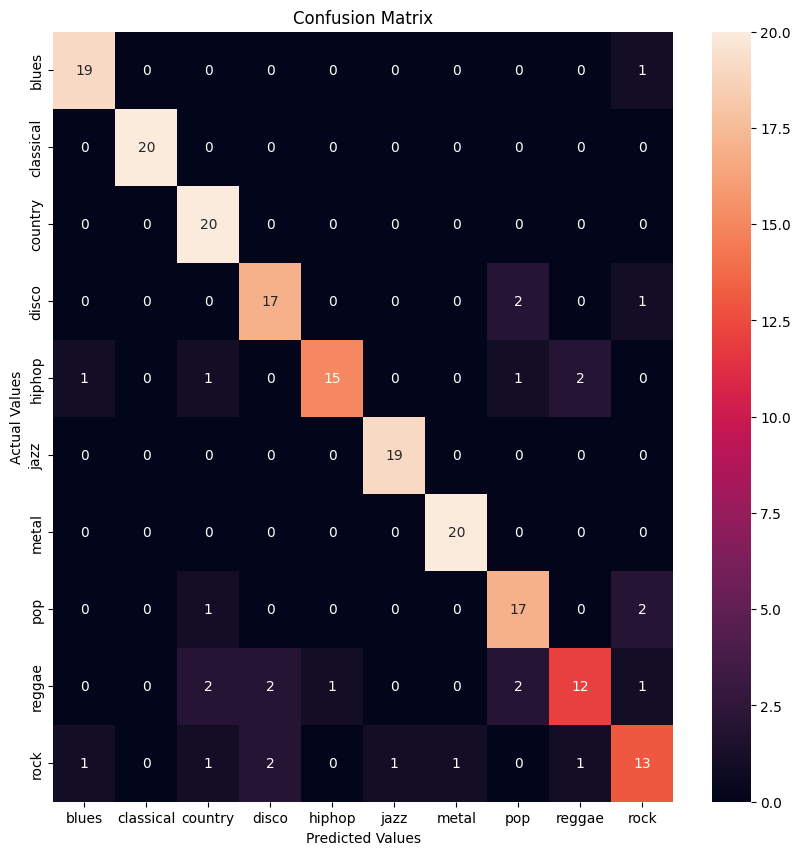

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix
y_test = y_test.reshape(-1,1)
model = SVC(kernel='rbf', max_iter = 50000,random_state=0,C=10,gamma=0.01,probability=True)
model.fit(X_tv_scaled,y_tv)
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test,y_pred)
cm_df = pd.DataFrame(cm,
                     index =df['label'].unique(), 
                     columns = df['label'].unique())


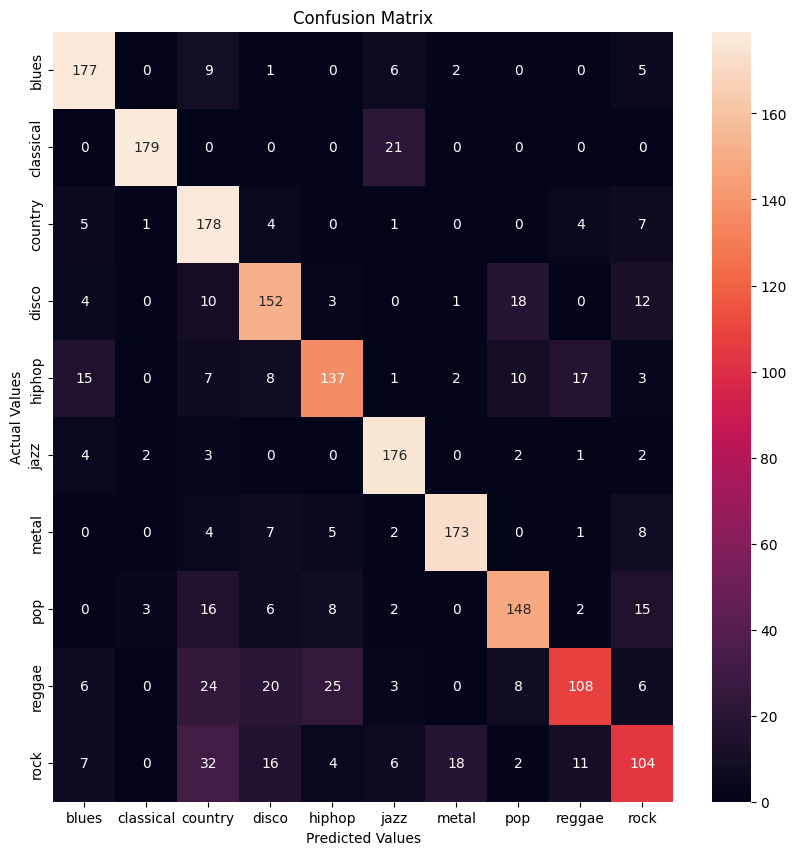

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

#### Afinando o grid search

In [6]:
X_tv, X_tv_scaled, X_test, X_test_scaled, X_train_scaled, X_val_scaled, y_tv, y_test, y_train, y_val = group_division(df)

In [9]:
param_grid = {'C':     10.0**np.arange(-3, 5.01, 1), 
              'gamma': 10.0**np.arange(-5, 3.01, 1)}
model = SVC(kernel='rbf', max_iter = 20000,random_state=0);
gs_svm = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_svm.best_score_)
print('best_params:', gs_svm.best_params_)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


best_score: 0.6641752129323831
best_params: {'C': 10.0, 'gamma': 0.01}


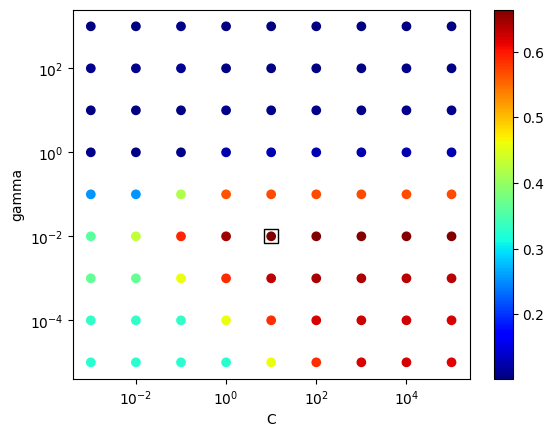

In [11]:
import matplotlib.pyplot as plt
plt.scatter(gs_svm.cv_results_['param_C'], gs_svm.cv_results_['param_gamma'], c=gs_svm.cv_results_['mean_test_score'], cmap='jet');
plt.plot(gs_svm.best_params_['C'], gs_svm.best_params_['gamma'], 'ks', mfc='none', markersize=10)
plt.xlabel('C')
plt.ylabel('gamma')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.show()

In [17]:
param_grid = {'C':     [2,5,10,20,30,50], 
              'gamma': [0.002,0.005,0.01,0.02,0.05]}
model = SVC(kernel='rbf', max_iter = 20000,random_state=0);
gs_svm = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_svm.best_score_)
print('best_params:', gs_svm.best_params_)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


best_score: 0.6641752129323831
best_params: {'C': 10, 'gamma': 0.01}


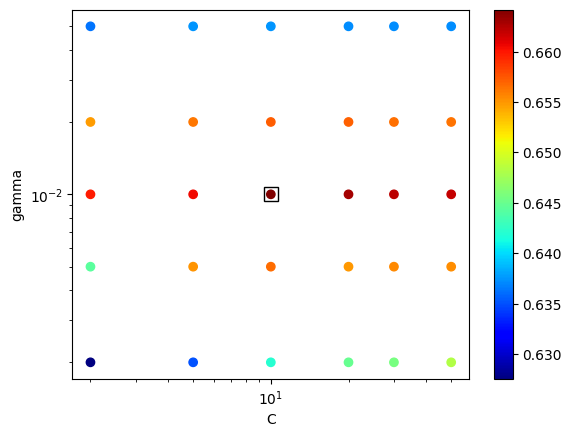

In [21]:
import matplotlib.pyplot as plt
plt.scatter(gs_svm.cv_results_['param_C'], gs_svm.cv_results_['param_gamma'], c=gs_svm.cv_results_['mean_test_score'], cmap='jet');
plt.plot(gs_svm.best_params_['C'], gs_svm.best_params_['gamma'], 'ks', mfc='none', markersize=10)
plt.xlabel('C')
plt.ylabel('gamma')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.show()

In [16]:
param_grid = {'C':     [9.5,10,10.5,], 
              'gamma': [0.0095,0.01,0.015,0.02]}
model = SVC(kernel='rbf', max_iter = 20000,random_state=0);
gs_svm = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_svm.best_score_)
print('best_params:', gs_svm.best_params_)

best_score: 0.6641752129323831
best_params: {'C': 10, 'gamma': 0.01}


### EDA:

- Problemas na divisão dos conjuntos no dataset original:
 - Afirma que todos os os arquivos possuem mesma length, sendo que não é possível em alguns casos len(y) < 66159 * 10
 - Retira a última janela quando o arquivo possui length menor que 66159 * 10 (em alguns casos). Ex: country00007 vai até country00007.8
 - Não há clareza sobre como foi feita a extração das features, qual o janelamento feito. 
 - Existem 307 casos em que len(y) < 66159 * 10, porém apenas em apenas 10 casos são retirados os trechos de número 9.
 - Há um arquivo corrompido (jazz.00054.wav)
 

### Extração manual das features:

- Alternativa:
    - Partindo de uma estratégia própria, realizar a extração manual e *garantir* coerência nos dados e labels, de modo que não sejam perdidas informações. Não será considerado o arquivo jazz.00054.wav, já que ele está corrompido e não é possível realizar a extração.
    - Para extrair as features, cada arquivo terá seu comprimento particionado em 10 partes, contendo aproximadamente 3 segundos cada. 
 

In [3]:
def extract_features(n_mfcc=20):

    import os
    general_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
    os.chdir(general_path)

    def compute_features(y,sr,i, folder):

        features=[]     
        features = (file[:-4] +'.' + str(i) + '.wav')
        features = np.append(features,len(y))
        features = np.append(features,np.mean(librosa.feature.chroma_stft(y=y,sr=sr)))
        features = np.append(features,np.var(librosa.feature.chroma_stft(y=y,sr=sr)))
        features = np.append(features, np.mean(librosa.feature.rms(y=y).flatten()))
        features = np.append(features, np.var(librosa.feature.rms(y=y).flatten()))
        features = np.append(features,librosa.feature.spectral_centroid(y=y,sr=sr).mean())
        features = np.append(features,librosa.feature.spectral_centroid(y=y,sr=sr).var())
        features = np.append(features,librosa.feature.spectral_bandwidth(y=y,sr=sr).mean())
        features = np.append(features,librosa.feature.spectral_bandwidth(y=y,sr=sr).var())
        features = np.append(features,librosa.feature.spectral_rolloff(y=y,sr=sr).mean())
        features = np.append(features,librosa.feature.spectral_rolloff(y=y,sr=sr).var())
        features = np.append(features,librosa.feature.zero_crossing_rate(y=y).mean())
        features = np.append(features,librosa.feature.zero_crossing_rate(y=y).var())
        harmony, perceptual = librosa.effects.hpss(y=y)
        features = np.append(features,harmony.mean()); features = np.append(features,harmony.var())
        features = np.append(features,perceptual.mean()); features = np.append(features,perceptual.var())
        tempo, beats = librosa.beat.beat_track(y=y,sr=sr); features = np.append(features,tempo)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        features = np.append(features,np.mean(mfccs,axis=1).reshape(-1,1))
        features = np.append(features,np.var(mfccs,axis=1).reshape(-1,1))
        features= np.append(features,folder)
    
        return features

    def read_file(file_path):
        y, sr = librosa.load(file_path)

        return y,sr

    path = np.sort(os.listdir());
    names=[]; labels = []

    test = np.empty((1,2*n_mfcc + 20 )); j=0
     # iterate through all file
    for folder in path:
        # Check whether file is in text format or not
        os.chdir(general_path+'/'+folder)
        for file in np.sort(os.listdir()):
            if file.endswith(".wav") and file != 'jazz.00054.wav':
                file_path = f"{general_path}/{folder}/{file}"
                
                y,sr = read_file(file_path)
                leny=len(y)
                winlen = int(np.floor(leny/10))
                if leny > winlen*10:
                    offset = leny-winlen*10
                else:
                    offset = 0
                
                for i in range(10):
                    window = y[winlen*i +offset:winlen*(i+1)+offset]
                    test = np.vstack((test,compute_features(window,sr,i,folder)))
    
                j=j+1
                
                print("file number: {}".format(j))
    
    print('Extraction complete, now saving into a DataFrame. ')
    
    columns = []
   
        
    columns.extend(['filename','length','chroma_stft_mean', 'chroma_stft_var','rms_mean','rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var',
                                   'rolloff_mean','rolloff_var','zero_crossing_rate_mean','zero_crossing_rate_var', 'harmony_mean','harmony_var', 'perceptr_mean','perceptr_var', 'tempo'])
    
    for i in range(n_mfcc):
        columns.append('mfcc' + str(i+1) + '_mean')
        columns.append('mfcc' + str(i+1) + '_var')
        
    columns.append('label')
    
    features = pd.DataFrame(test, columns = columns)
    features = features.drop(index=0)
    features= features.reset_index()
    features = features.drop(columns='index')
      
    return features, test


In [9]:
df,test = extract_features()
df.to_csv('/kaggle/working/features3sec_manual.csv', index = False)

file number: 1
file number: 2
file number: 3
file number: 4
file number: 5
file number: 6
file number: 7
file number: 8
file number: 9
file number: 10
file number: 11
file number: 12
file number: 13
file number: 14
file number: 15
file number: 16
file number: 17
file number: 18
file number: 19
file number: 20
file number: 21
file number: 22
file number: 23
file number: 24
file number: 25
file number: 26
file number: 27
file number: 28
file number: 29
file number: 30
file number: 31
file number: 32
file number: 33
file number: 34
file number: 35
file number: 36
file number: 37
file number: 38
file number: 39
file number: 40
file number: 41
file number: 42
file number: 43
file number: 44
file number: 45
file number: 46
file number: 47
file number: 48
file number: 49
file number: 50
file number: 51
file number: 52
file number: 53
file number: 54
file number: 55
file number: 56
file number: 57
file number: 58
file number: 59
file number: 60
file number: 61
file number: 62
file number: 63
f

In [97]:
df = pd.read_csv('/kaggle/input/features-manual/features_3_sec_final.csv')
df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66179,0.335419,0.090920,0.130216,0.003553,1773.168464,168550.931397,1972.748808,117840.090407,...,45.126217,34.097060,47.276480,42.716015,39.442127,36.642020,37.515717,33.613953,43.593520,blues
1,blues.00000.1.wav,66179,0.343382,0.086456,0.112240,0.001472,1819.394632,90842.098987,2014.086527,68063.797587,...,41.949640,29.924103,50.579628,68.859170,65.845390,40.585790,50.657143,98.060720,60.313090,blues
2,blues.00000.2.wav,66179,0.346068,0.092088,0.130903,0.004571,1793.284134,109660.466230,2092.217240,74317.677016,...,40.185673,40.114418,27.060625,50.012370,68.641010,28.436958,44.956963,52.609980,32.879300,blues
3,blues.00000.3.wav,66179,0.363388,0.086984,0.131371,0.002355,1658.544058,110718.095660,1964.485296,81606.479177,...,41.842250,60.600900,34.942368,43.857784,47.895990,30.508402,32.006416,51.278885,31.737726,blues
4,blues.00000.4.wav,66179,0.333218,0.087470,0.142369,0.001710,1633.417701,78307.000551,1951.100894,58963.022352,...,45.452050,46.003597,24.952505,40.714200,30.458221,44.605793,50.638084,26.614265,29.812023,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66179,0.350895,0.081530,0.049631,0.000098,1499.254291,163627.839279,1719.241872,85412.497324,...,43.812220,53.144424,30.162931,80.848860,39.582485,37.179707,30.757494,46.725784,38.432910,rock
9986,rock.00099.6.wav,66179,0.372275,0.082420,0.057613,0.000096,1850.819736,276764.595666,1913.073910,96929.695783,...,42.006542,37.710840,46.777878,34.196507,32.623837,71.080060,54.277637,62.652283,18.596706,rock
9987,rock.00099.7.wav,66179,0.346482,0.087981,0.052045,0.000680,1353.931397,664928.983449,1571.806887,140868.337269,...,34.203000,28.635513,97.818870,41.599854,77.885260,22.745342,25.259607,45.908318,42.537180,rock
9988,rock.00099.8.wav,66179,0.385419,0.083225,0.065870,0.000313,2081.218952,204241.458651,2017.261715,22301.966902,...,24.152521,18.999252,17.899761,20.207003,26.538494,17.655598,22.282140,25.229414,12.778382,rock


#### Realizando a divisão agrupada dos conjuntos: 

In [6]:
import warnings
warnings.filterwarnings('ignore')

import sklearn

def group_division(df):

    data = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv')
    a = sklearn.utils.shuffle(data,random_state=0)
    a = a.drop(554)

    labels = np.unique(a['label'])
    files = []
    for i in labels:
        for k in range(80):
            for j in range(10):
                files.append((a[a['label']== i].iloc[k]['filename']))

    for i in range(800):
        for j in range(10):
            files[10*i+j] = (files[10*i+j])[:-4] + '.' + str(j) + '.wav'

        #data = pd.read_csv('/kaggle/input/features-manual/features3sec_extended.csv')
    train_val = pd.DataFrame()
    for i in files:
        train_val = pd.concat([train_val,df.loc[df['filename'] == i]])
           #train_val = train_val.append(df.loc[df['filename'] == i])
    test= df.drop(train_val.index)

    b = sklearn.utils.shuffle(train_val,random_state=0)

    files = []
    for i in labels:
        for k in range(60):
            for j in range(10):
                files.append((b[b['label']== i].iloc[k]['filename']))

    for i in range(600):
        for j in range(10):
            files[10*i+j] = (files[10*i+j])[:-6] + '.' + str(j) + '.wav'


    train = pd.DataFrame()
    for i in files:
        train = pd.concat([train,train_val.loc[train_val['filename'] == i]])
    val = df.drop(train.index)
#train
    
    X_tv = train_val.drop(columns=['label','filename','length']); y_tv = train_val['label']
    X_train = train.drop(columns=['label','filename','length']); y_train = train['label']
    X_val = val.drop(columns=['label','filename','length']); y_val = val['label']
    X_test = test.drop(columns=['label','filename','length']); y_test = test['label']
    scaler = StandardScaler(); scaler.fit(X_tv); X_tv_scaled = scaler.transform(X_tv); X_test_scaled = scaler.transform(X_test);
    scaler.fit(X_train); X_train_scaled = scaler.transform(X_train); X_val_scaled = scaler.transform(X_val); 
    
    return X_tv, X_tv_scaled, X_test, X_test_scaled, X_train_scaled, X_val_scaled, y_tv, y_test, y_train, y_val


#X_tv, X_tv_scaled, X_test, X_test_scaled, X_train_scaled, X_val_scaled, y_tv, y_test, y_train, y_val = group_division(df)

#### Retreinando e otimizando os modelos: 

##### Logistic Regression:

In [92]:
param_grid = dict()
param_grid['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1,0.5, 1,2, 5, 10,15,30,50, 100]
model = LogisticRegression(max_iter=50000, solver='newton-cg', multi_class = 'multinomial')
gs_l = grid_search(model, param_grid, X_train_scaled, y_train,X_val_scaled,y_val)
print('best_score:', gs_l.best_score_)
print('best_params:', gs_l.best_params_)

best_score: 0.6112115732368897
best_params: {'C': 2}


In [93]:
model = LogisticRegression(max_iter=50000, solver='newton-cg', multi_class = 'multinomial',**gs_l.best_params_)
model.fit(X_train_scaled,y_train)
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled,y_tv)
print(f'Test refited accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Test accuracy: 60.8%
Test refited accuracy: 66.2%


##### SVM:

In [84]:
param_grid = {'C':     10.0**np.arange(-4, 5.01, 1), 
              'gamma': 10.0**np.arange(-5, 3.01, 1)}
model = SVC(kernel='rbf', max_iter = 100000,random_state=0);
gs_svm = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_svm.best_score_)
print('best_params:', gs_svm.best_params_)

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


best_score: 0.6484629294755877
best_params: {'C': 10.0, 'gamma': 0.01}


In [86]:
model = SVC(kernel='rbf', max_iter = 100000,random_state=0, **gs_svm.best_params_)
model.fit(X_train_scaled,y_train)
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled,y_tv)
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Test accuracy: 64.7%
Test accuracy: 73.8%


##### KNN:

In [87]:
model = KNeighborsClassifier()
param_grid = { 'n_neighbors' : [1,2,3,5,7,9,11,13,15,20],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

gs_knn = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_knn.best_score_)
print('best_params:', gs_knn.best_params_)

best_score: 0.5949367088607594
best_params: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}


In [91]:
model = KNeighborsClassifier(**gs_knn.best_params_)
model.fit(X_train_scaled, y_train)
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled,y_tv)
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Test accuracy: 59.1%
Test accuracy: 68.1%


##### Random Forest: 

In [99]:
n_estimators = [250]
max_depth = [50,80,100,120]
msl = [1,2,5,10,20,50]
ccp_alpha = 10**np.arange(-4,1.01,1)

param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, ccp_alpha=ccp_alpha)
model = RandomForestClassifier(random_state=0,n_jobs=-1)

gs_forest = grid_search(model,param_grid, X_train_scaled, y_train, X_val_scaled,y_val)
print('best_score:', gs_forest.best_score_)
print('best_params:', gs_forest.best_params_)

best_score: 0.6305605786618445
best_params: {'ccp_alpha': 0.0001, 'max_depth': 50, 'n_estimators': 250}


In [100]:
model = RandomForestClassifier(**gs_forest.best_params_, random_state=0, n_jobs=-1)
model.fit(X_train_scaled, y_train)
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled,y_tv)
print(f'Test refited accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')


Test accuracy: 63.9%
Test refited accuracy: 72.0%


In [34]:
corr = pd.DataFrame(data= gs_forest.best_estimator_.feature_importances_, index=scaler.feature_names_in_)
corr = corr.sort_values(by =0, ascending =False)

##### Gradient Booster: 

In [101]:
#learning_rate = 10**np.arange(-2,0.01,1)
learning_rate = [0.001]
n_estimators = [100]
param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate)

model = GradientBoostingClassifier(random_state=0,n_iter_no_change = 200,max_features = 'sqrt')
model.fit(X_train_scaled,y_train)
#gs_grad = grid_search(model, param_grid, X_train_scaled, y_train,X_val_scaled, y_val)
#print('best_score:', gs_forest.best_score_)
#print('best_params:', gs_grad.best_params_)
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
print(f'Test accuracy : {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled,y_tv)
print(f'Test refited accuracy : {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Validation accuracy: 63.5%
Test accuracy : 64.3%
Test refited accuracy : 70.0%


In [106]:
model = MLPClassifier(hidden_layer_sizes=(1000,500,200), max_iter = 2000,activation = 'relu', solver = 'adam',learning_rate = 'adaptive',
                      random_state=0, alpha = 1e-5)
model.fit(X_train_scaled,y_train)
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled,y_tv)
print(f'Test refited accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Validation accuracy: 65.8%
Test accuracy: 64.4%
Test refited accuracy: 72.5%


### Adicionando features extra

Features escolhidas:
   - Spectral: entropy, crest, skewness, slope, decrease, contrast, spread, flatness, flux, variability. 
   - Peak: smoothness.

In [7]:
from scipy.fft import fft
from scipy.signal import spectrogram
from scipy.stats import kurtosis
from scipy.stats import linregress
from scipy.stats import skew
from scipy.stats import entropy

In [5]:
def extract_features_extended(data):

    import os
    general_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
    os.chdir(general_path)
    nperseg=2048

    def compute_features(y,sr,i, folder):

        _, _, spectrogram_data = spectrogram(x=y, fs=sr, nperseg=2048)
        spectrogram_data = np.abs(spectrogram_data)  # Take the absolute value of the spectrogram
        power_spectrum = np.mean(spectrogram_data, axis=1)
        normalized_spectrum = power_spectrum / np.sum(power_spectrum)
        frequency_axis = np.fft.rfftfreq(nperseg, 1 / sr)
        log_power_spectrum = np.log10(power_spectrum)
        energy = np.sum(spectrogram_data, axis=1)
        n_frames = energy.shape[0]
        
        spectral_entropy = entropy(normalized_spectrum, base=2)
        spread = np.sqrt(np.sum((frequency_axis[:, np.newaxis] - np.mean(frequency_axis)) ** 2 * power_spectrum[:, np.newaxis]) / np.sum(power_spectrum))
        skewness = skew(power_spectrum)
        slope, _, _, _, _ = linregress(frequency_axis, log_power_spectrum)
        #skurtosis = np.zeros(normalized_spectrum.shape[0])
        #for i in range(normalized_spectrum.shape[0]):
        #    skurtosis[i] = kurtosis(normalized_spectrum[i])
        decrease = np.zeros(n_frames)
        for i in range(1, n_frames):
            decrease[i] = np.sum(energy[i:] - energy[i - 1]) / (n_frames - i)
            
        peak_amplitude = np.max(np.abs(y))
        diff = np.diff(y)  # Compute the differences between consecutive samples
        mean_diff = np.mean(np.abs(diff))  # Calculate the mean absolute difference
        smoothness = mean_diff / peak_amplitude
        
        
        
        features=[]   
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        features = np.mean(contrast); features = np.append(features,np.var(contrast)) #spectral contrast mean + var
        stft = librosa.stft(y=y);  magnitude = np.abs(stft); flux = librosa.onset.onset_strength(S=magnitude,sr=sr); 
        features = np.append(features, np.mean(flux)); features = np.append(features,np.var(flux)) #spectral flux mean + var
        crest = np.max(magnitude, axis=0) / (np.sum(magnitude, axis=0) + 1e-10)
        features = np.append(features, np.mean(crest)); features = np.append(features, np.var(crest)) #spectral crest mean + var
        flatness = librosa.feature.spectral_flatness(y=y)
        features = np.append(features, np.mean(flatness)); features = np.append(features, np.var(flatness)) #spectral flatness mean + var
        features = np.append(features, np.mean(decrease)); features = np.append(features, np.var(decrease)) #spectral decrease mean + var
        #features = np.append(features, np.mean(skurtosis)); features = np.append(features, np.var(skurtosis)) #spectral kurtosis mean + var
        features = np.append(features, slope); #spectral slope 
        features = np.append(features, skewness); #spectral skewness
        features = np.append(features, spread); #spectral spread 
        features = np.append(features, spectral_entropy); #spectral entropy 
        features = np.append(features, np.var(spectrogram_data)); # spectral variability 
        features = np.append(features, smoothness); # peak smoothness
        
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        beat_histogram = librosa.feature.tempogram(y=y, sr=sr, hop_length=2048, win_length=4096)
        beat_histogram = np.mean(beat_histogram, axis=0)
        beat_histogram /= np.max(beat_histogram)
        #beat_histogram = beat_histogram[0:129]
        
        features = np.append(features, beat_histogram); # peak smoothness
        
        return features

    def read_file(file_path):
        y, sr = librosa.load(file_path)

        return y,sr

    path = np.sort(os.listdir());
    names=[]; labels = []

    test = np.empty((1,16+33)); j=0
     # iterate through all file
    for folder in path:
        # Check whether file is in text format or not
        os.chdir(general_path+'/'+folder)
        for file in np.sort(os.listdir()):
            if file.endswith(".wav") and file != 'jazz.00054.wav':
                file_path = f"{general_path}/{folder}/{file}"
                
                y,sr = read_file(file_path)
                leny=len(y)
                winlen = int(np.floor(leny/10))
                if leny > winlen*10:
                    offset = leny-winlen*10
                else:
                    offset = 0
                
                for i in range(10):
                    window = y[winlen*i +offset:winlen*(i+1)+offset]
                    test = np.vstack((test,compute_features(window,sr,i,folder)))
    
                j=j+1
                
                print("file number: {}".format(j))
    
    print('Extraction complete, now saving into a DataFrame. ')
    
    columns = ['spectral_contrast_mean', 'spectral_contrast_var','spectral_flux_mean','spectral_flux_var','spectral_crest_mean','spectral_crest_var',
                    'spectral_flatness_mean','spectral_flatness_var','spectral_decrease_mean','spectral_decrease_var', 'spectral_slope', 'spectral_skewness',
                   'spectral_spread', 'spectral_entropy','spectral_variability','peak_smoothness']
      
    hist=[]
    for i in range(33):
        hist.append('beat_hist_'+str(i))
        
    columns.extend(hist)
    
    features = pd.DataFrame(test, columns = columns)
    features = features.drop(index=0)
    features= features.reset_index()
    features = features.drop(columns='index')
    data = pd.concat([data, features], axis=1)
    #data[columns] = features[columns]
      
    return data, features

In [6]:
df = pd.read_csv('/kaggle/input/features-manual/features_3_sec_final.csv')
df_extended, f = extract_features_extended(df)

file number: 1
file number: 2
file number: 3
file number: 4
file number: 5
file number: 6
file number: 7
file number: 8
file number: 9
file number: 10
file number: 11
file number: 12
file number: 13
file number: 14
file number: 15
file number: 16
file number: 17
file number: 18
file number: 19
file number: 20
file number: 21
file number: 22
file number: 23
file number: 24
file number: 25
file number: 26
file number: 27
file number: 28
file number: 29
file number: 30
file number: 31
file number: 32
file number: 33
file number: 34
file number: 35
file number: 36
file number: 37
file number: 38
file number: 39
file number: 40
file number: 41
file number: 42
file number: 43
file number: 44
file number: 45
file number: 46
file number: 47
file number: 48
file number: 49
file number: 50
file number: 51
file number: 52
file number: 53
file number: 54
file number: 55
file number: 56
file number: 57
file number: 58
file number: 59
file number: 60
file number: 61
file number: 62
file number: 63
f

In [7]:
df_extended.to_csv('/kaggle/working/features3sec_extended_beathist33.csv', index = False)
df_extended

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,beat_hist_23,beat_hist_24,beat_hist_25,beat_hist_26,beat_hist_27,beat_hist_28,beat_hist_29,beat_hist_30,beat_hist_31,beat_hist_32
0,blues.00000.0.wav,66179,0.335419,0.090920,0.130216,0.003553,1773.168464,168550.931397,1972.748808,117840.090407,...,0.995341,0.995859,0.996377,0.996894,0.997412,0.997929,0.998447,0.998965,0.999482,1.0
1,blues.00000.1.wav,66179,0.343382,0.086456,0.112240,0.001472,1819.394632,90842.098987,2014.086527,68063.797587,...,0.994982,0.995540,0.996097,0.996655,0.997212,0.997770,0.998327,0.998885,0.999442,1.0
2,blues.00000.2.wav,66179,0.346068,0.092088,0.130903,0.004571,1793.284134,109660.466230,2092.217240,74317.677016,...,0.993718,0.994415,0.995112,0.995810,0.996508,0.997206,0.997904,0.998602,0.999301,1.0
3,blues.00000.3.wav,66179,0.363388,0.086984,0.131371,0.002355,1658.544058,110718.095660,1964.485296,81606.479177,...,0.992825,0.993620,0.994416,0.995213,0.996010,0.996807,0.997605,0.998403,0.999201,1.0
4,blues.00000.4.wav,66179,0.333218,0.087470,0.142369,0.001710,1633.417701,78307.000551,1951.100894,58963.022352,...,0.994646,0.995241,0.995836,0.996430,0.997025,0.997620,0.998215,0.998810,0.999405,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66179,0.350895,0.081530,0.049631,0.000098,1499.254291,163627.839279,1719.241872,85412.497324,...,0.992509,0.993339,0.994170,0.995002,0.995833,0.996666,0.997498,0.998332,0.999166,1.0
9986,rock.00099.6.wav,66179,0.372275,0.082420,0.057613,0.000096,1850.819736,276764.595666,1913.073910,96929.695783,...,0.995014,0.995568,0.996122,0.996676,0.997230,0.997784,0.998338,0.998892,0.999446,1.0
9987,rock.00099.7.wav,66179,0.346482,0.087981,0.052045,0.000680,1353.931397,664928.983449,1571.806887,140868.337269,...,0.995227,0.995757,0.996287,0.996818,0.997348,0.997878,0.998409,0.998939,0.999470,1.0
9988,rock.00099.8.wav,66179,0.385419,0.083225,0.065870,0.000313,2081.218952,204241.458651,2017.261715,22301.966902,...,0.995581,0.996072,0.996563,0.997054,0.997545,0.998036,0.998527,0.999018,0.999509,1.0


In [108]:
df = pd.read_csv('/kaggle/input/features-manual/features3sec_extended.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,spectral_flatness_mean,spectral_flatness_var,spectral_decrease_mean,spectral_decrease_var,spectral_slope,spectral_skewness,spectral_spread,spectral_entropy,spectral_variability,peak_smoothness
0,blues.00000.0.wav,66179,0.335419,0.090920,0.130216,0.003553,1773.168464,168550.931397,1972.748808,117840.090407,...,0.005150,0.000143,-0.000065,6.686095e-08,-0.000576,6.656749,4936.658306,6.750420,6.809484e-10,0.032148
1,blues.00000.1.wav,66179,0.343382,0.086456,0.112240,0.001472,1819.394632,90842.098987,2014.086527,68063.797587,...,0.004881,0.000047,-0.000044,3.489548e-08,-0.000565,8.302105,4948.343234,6.808818,1.681873e-10,0.036451
2,blues.00000.2.wav,66179,0.346068,0.092088,0.130903,0.004571,1793.284134,109660.466230,2092.217240,74317.677016,...,0.004004,0.000015,-0.000066,3.005427e-07,-0.000555,19.841906,5027.881687,5.651959,1.871393e-09,0.030276
3,blues.00000.3.wav,66179,0.363388,0.086984,0.131371,0.002355,1658.544058,110718.095660,1964.485296,81606.479177,...,0.003711,0.000011,-0.000059,5.324366e-08,-0.000568,5.804484,4964.472583,6.741075,3.380251e-10,0.033633
4,blues.00000.4.wav,66179,0.333218,0.087470,0.142369,0.001710,1633.417701,78307.000551,1951.100894,58963.022352,...,0.003292,0.000009,-0.000069,9.841851e-08,-0.000574,7.610347,4985.108886,6.516251,3.909193e-10,0.034065


In [109]:
import warnings
warnings.filterwarnings('ignore')

import sklearn

def group_division(df):

    data = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv')
    a = sklearn.utils.shuffle(data,random_state=0)
    a = a.drop(554)

    labels = np.unique(a['label'])
    files = []
    for i in labels:
        for k in range(80):
            for j in range(10):
                files.append((a[a['label']== i].iloc[k]['filename']))

    for i in range(800):
        for j in range(10):
            files[10*i+j] = (files[10*i+j])[:-4] + '.' + str(j) + '.wav'

        #data = pd.read_csv('/kaggle/input/features-manual/features3sec_extended.csv')
    train_val = pd.DataFrame()
    for i in files:
        train_val = pd.concat([train_val,df.loc[df['filename'] == i]])
           #train_val = train_val.append(df.loc[df['filename'] == i])
    test= df.drop(train_val.index)

    b = sklearn.utils.shuffle(train_val,random_state=0)

    files = []
    for i in labels:
        for k in range(60):
            for j in range(10):
                files.append((b[b['label']== i].iloc[k]['filename']))

    for i in range(600):
        for j in range(10):
            files[10*i+j] = (files[10*i+j])[:-6] + '.' + str(j) + '.wav'


    train = pd.DataFrame()
    for i in files:
        train = pd.concat([train,train_val.loc[train_val['filename'] == i]])
    val = df.drop(train.index)
#train
    
    X_tv = train_val.drop(columns=['label','filename','length']); y_tv = train_val['label']
    X_train = train.drop(columns=['label','filename','length']); y_train = train['label']
    X_val = val.drop(columns=['label','filename','length']); y_val = val['label']
    X_test = test.drop(columns=['label','filename','length']); y_test = test['label']
    scaler = StandardScaler(); scaler.fit(X_tv); X_tv_scaled = scaler.transform(X_tv); X_test_scaled = scaler.transform(X_test);
    scaler.fit(X_train); X_train_scaled = scaler.transform(X_train); X_val_scaled = scaler.transform(X_val); 
    
    return X_tv, X_tv_scaled, X_test, X_test_scaled, X_train_scaled, X_val_scaled, y_tv, y_test, y_train, y_val


X_tv, X_tv_scaled, X_test, X_test_scaled, X_train_scaled, X_val_scaled, y_tv, y_test, y_train, y_val = group_division(df)

In [110]:
param_grid = {'C':     10.0**np.arange(-4, 5.01, 1), 
              'gamma': 10.0**np.arange(-5, 3.01, 1)}
model = SVC(kernel='rbf', max_iter = 50000,random_state=0);
gs_svm = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_svm.best_score_)
print('best_params:', gs_svm.best_params_)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


best_score: 0.6824593128390597
best_params: {'C': 10.0, 'gamma': 0.01}


In [111]:
model = SVC(kernel='rbf', max_iter = 50000,random_state=0, **gs_svm.best_params_);
model.fit(X_train_scaled, y_train)
print(f'Test accuracy (SVM): {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled, y_tv)
print(f'Test accuracy (SVM): {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Test accuracy (SVM): 68.2%
Test accuracy (SVM): 76.7%


In [145]:
model = MLPClassifier(hidden_layer_sizes=(1000,500,200), max_iter = 10000,activation = 'relu', solver = 'adam',
                      random_state=0)
model.fit(X_train_scaled,y_train)
print(f'Train accuracy: {accuracy_score(y_train, model.predict(X_train_scaled)):.1%}')
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Train accuracy: 100.0%
Validation accuracy: 69.1%
Test accuracy: 70.9%


#### Teste Features originais (CSV) + extra

In [119]:
df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
df_ex = pd.read_csv('/kaggle/input/features-manual/features3sec_extended.csv')
extra = df_ex.columns[60::]
df[extra] = df_ex[extra]
X_tv, X_tv_scaled, X_test, X_test_scaled, X_train_scaled, X_val_scaled, y_tv, y_test, y_train, y_val = group_division(df)

In [120]:
param_grid = {'C':     10.0**np.arange(-4, 5.01, 1), 
              'gamma': 10.0**np.arange(-5, 3.01, 1)}
model = SVC(kernel='rbf', max_iter = 50000,random_state=0);
gs_svm = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_svm.best_score_)
print('best_params:', gs_svm.best_params_)

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


best_score: 0.6966799930471058
best_params: {'C': 10.0, 'gamma': 0.01}


In [121]:
model = SVC(kernel='rbf', max_iter = 50000,random_state=0, **gs_svm.best_params_);
model.fit(X_train_scaled, y_train)
print(f'Test accuracy (SVM): {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled, y_tv)
print(f'Test accuracy (SVM): {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Test accuracy (SVM): 69.9%
Test accuracy (SVM): 77.8%


#### Utilizando o Beat Histogram como feature adicional: 

In [179]:
df = pd.read_csv('/kaggle/input/features-manual/features3sec_extended_beathist33.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,beat_hist_23,beat_hist_24,beat_hist_25,beat_hist_26,beat_hist_27,beat_hist_28,beat_hist_29,beat_hist_30,beat_hist_31,beat_hist_32
0,blues.00000.0.wav,66179,0.335419,0.090920,0.130216,0.003553,1773.168464,168550.931397,1972.748808,117840.090407,...,0.995341,0.995859,0.996377,0.996894,0.997412,0.997929,0.998447,0.998965,0.999482,1.0
1,blues.00000.1.wav,66179,0.343382,0.086456,0.112240,0.001472,1819.394632,90842.098987,2014.086527,68063.797587,...,0.994982,0.995540,0.996097,0.996655,0.997212,0.997770,0.998327,0.998885,0.999442,1.0
2,blues.00000.2.wav,66179,0.346068,0.092088,0.130903,0.004571,1793.284134,109660.466230,2092.217240,74317.677016,...,0.993718,0.994415,0.995112,0.995810,0.996508,0.997206,0.997904,0.998602,0.999301,1.0
3,blues.00000.3.wav,66179,0.363388,0.086984,0.131371,0.002355,1658.544058,110718.095660,1964.485296,81606.479177,...,0.992825,0.993620,0.994416,0.995213,0.996010,0.996807,0.997605,0.998403,0.999201,1.0
4,blues.00000.4.wav,66179,0.333218,0.087470,0.142369,0.001710,1633.417701,78307.000551,1951.100894,58963.022352,...,0.994646,0.995241,0.995836,0.996430,0.997025,0.997620,0.998215,0.998810,0.999405,1.0


In [180]:
from sklearn.compose import make_column_transformer

def group_division_beathist(data):
    classes = np.unique(data['label'])
    data['label2'] = 0 
    j=0; k=0; i =0; count2=0
    while i < 9990:    
        for label in classes:
            if data.loc[i,'filename'].startswith(label):
                temp = (df.loc[i,'filename'])[:-6]
                count = 0
                while data.loc[i,'filename'].startswith(temp):
                    i=i+1; count=count+1
                    if i >= 9990:
                        break

                count2=count2+1
                data.loc[(i-count):(i), 'label2'] = count2

    X = data.drop(columns=['label','label2'])
    y = data['label'].to_numpy()
    g = data['label2']
    X, X_test, y, y_test, g, g_test = group_train_test_split(X, y, g, test_size=199, groups=g, random_state=0) 
    X_train, X_val, y_train, y_val, g_train, g_val = group_train_test_split(X, y, g, test_size=400, groups=g, random_state=0)
    X_train = X_train.drop(['length', 'filename'], axis=1); X_val = X_val.drop(['length', 'filename'], axis=1); X_test = X_test.drop(['length', 'filename'], axis=1); 

    tfeatures = X_train.columns[0:73]
    scaler = make_column_transformer((StandardScaler(),tfeatures),remainder='passthrough');
    scaler.fit(X_train); scaler.fit(X_train); X_train_scaled = scaler.transform(X_train); X_val_scaled = scaler.transform(X_val); X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = group_division_beathist(df)

#### Beat hist: 65 dim

In [95]:
param_grid = {'C':     10.0**np.arange(-4, 5.01, 1), 
              'gamma': 10.0**np.arange(-5, 3.01, 1)}
model = SVC(kernel='rbf', max_iter = 10000,random_state=0);
gs_svm = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_svm.best_score_)
print('best_params:', gs_svm.best_params_)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


best_score: 0.69275
best_params: {'C': 100.0, 'gamma': 0.01}


In [96]:
print(f'Test accuracy (SVM): {accuracy_score(y_test, gs_svm.predict(X_test_scaled)):.1%}')

Test accuracy (SVM): 75.2%


In [181]:
model = MLPClassifier(hidden_layer_sizes=(1000,1000), max_iter = 10000,activation = 'relu', solver = 'adam',
                      random_state=6)
model.fit(X_train_scaled,y_train)
print(f'Train accuracy: {accuracy_score(y_train, model.predict(X_train_scaled)):.1%}')
print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val_scaled)):.1%}')
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Train accuracy: 100.0%
Validation accuracy: 69.8%
Test accuracy: 71.1%


#### Beat hist: 129 dim

In [15]:
param_grid = {'C':     10.0**np.arange(-4, 5.01, 1), 
              'gamma': 10.0**np.arange(-5, 3.01, 1)}
model = SVC(kernel='rbf', max_iter = 10000,random_state=0);
gs_svm = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_svm.best_score_)
print('best_params:', gs_svm.best_params_)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


best_score: 0.69425
best_params: {'C': 100.0, 'gamma': 0.01}


In [16]:
print(f'Test accuracy (SVM): {accuracy_score(y_test, gs_svm.predict(X_test_scaled)):.1%}')

Test accuracy (SVM): 74.7%


#### Beat hist 33 dim:

In [18]:
param_grid = {'C':     10.0**np.arange(-4, 5.01, 1), 
              'gamma': 10.0**np.arange(-5, 3.01, 1)}
model = SVC(kernel='rbf', max_iter = 100000,random_state=0);
gs_svm = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_svm.best_score_)
print('best_params:', gs_svm.best_params_)

best_score: 0.6925
best_params: {'C': 100.0, 'gamma': 0.01}


#### Beat hist: aumentou consideravelmente o processamento mas não produziu ganhos consideráveis no desempenho

#### Mudando o problema:

- Nessa próxima abordagem, serão mantidas 800 entradas para o conjunto de treino+val, e 199 para o teste. No entanto, para cada arquivo, serão retiradas 50 features de cada trecho de 3s, 50 features para dois trechos de 15s, e 50 features do arquivo completo. 

In [7]:
from scipy.fft import fft
from scipy.signal import spectrogram
from scipy.stats import kurtosis
from scipy.stats import linregress
from scipy.stats import skew
from scipy.stats import entropy

def extract_features_plus(n_mfcc=25):

    import os
    general_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
    os.chdir(general_path)
    nperseg=2048

    def compute_features(y,sr):
        
        _, _, spectrogram_data = spectrogram(x=y, fs=sr, nperseg=2048)
        spectrogram_data = np.abs(spectrogram_data)  # Take the absolute value of the spectrogram
        power_spectrum = np.mean(spectrogram_data, axis=1)
        normalized_spectrum = power_spectrum / np.sum(power_spectrum)
        frequency_axis = np.fft.rfftfreq(nperseg, 1 / sr)
        log_power_spectrum = np.log10(power_spectrum)
        energy = np.sum(spectrogram_data, axis=1)
        n_frames = energy.shape[0]
        
        spectral_entropy = entropy(normalized_spectrum, base=2)
        spread = np.sqrt(np.sum((frequency_axis[:, np.newaxis] - np.mean(frequency_axis)) ** 2 * power_spectrum[:, np.newaxis]) / np.sum(power_spectrum))
        skewness = skew(power_spectrum)
        slope, _, _, _, _ = linregress(frequency_axis, log_power_spectrum)
        decrease = np.zeros(n_frames)
        for i in range(1, n_frames):
            decrease[i] = np.sum(energy[i:] - energy[i - 1]) / (n_frames - i)
            
        peak_amplitude = np.max(np.abs(y))
        diff = np.diff(y)  # Compute the differences between consecutive samples
        mean_diff = np.mean(np.abs(diff))  # Calculate the mean absolute difference
        smoothness = mean_diff / peak_amplitude 
        
        features = []
        features = np.append(features,np.mean(librosa.feature.chroma_stft(y=y,sr=sr)))
        features = np.append(features,np.var(librosa.feature.chroma_stft(y=y,sr=sr)))
        features = np.append(features, np.mean(librosa.feature.rms(y=y).flatten()))
        features = np.append(features, np.var(librosa.feature.rms(y=y).flatten()))
        features = np.append(features,librosa.feature.spectral_centroid(y=y,sr=sr).mean())
        features = np.append(features,librosa.feature.spectral_centroid(y=y,sr=sr).var())
        features = np.append(features,librosa.feature.spectral_bandwidth(y=y,sr=sr).mean())
        features = np.append(features,librosa.feature.spectral_bandwidth(y=y,sr=sr).var())
        features = np.append(features,librosa.feature.spectral_rolloff(y=y,sr=sr).mean())
        features = np.append(features,librosa.feature.zero_crossing_rate(y=y).mean())
        harmony, perceptual = librosa.effects.hpss(y=y)
        features = np.append(features,harmony.var())
        features = np.append(features,perceptual.mean()); features = np.append(features,perceptual.var())
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        features = np.append(features,np.mean(mfccs,axis=1).reshape(-1,1))
        features = np.append(features,np.var(mfccs,axis=1).reshape(-1,1))
        
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        features = np.append(features,np.mean(contrast));
        features = np.append(features,np.var(contrast)) #spectral contrast mean + var
        stft = librosa.stft(y=y);  magnitude = np.abs(stft); flux = librosa.onset.onset_strength(S=magnitude,sr=sr); 
        features = np.append(features, np.mean(flux)); features = np.append(features,np.var(flux)) #spectral flux mean + var
        crest = np.max(magnitude, axis=0) / (np.sum(magnitude, axis=0) + 1e-10)
        features = np.append(features, np.mean(crest)); 
        flatness = librosa.feature.spectral_flatness(y=y)
        features = np.append(features, np.var(flatness)) #spectral flatness mean + var
        features = np.append(features, np.mean(decrease)); 
        features = np.append(features, slope); #spectral slope 
        features = np.append(features, skewness); #spectral skewness
        features = np.append(features, spread); #spectral spread 
        features = np.append(features, spectral_entropy); #spectral entropy 
        features = np.append(features, smoothness); # peak smoothness
    
        return features

    def read_file(file_path):
        y, sr = librosa.load(file_path)

        return y,sr

    path = np.sort(os.listdir());
    names=[]; labels = []

    j=0
    f2 = np.empty((1,828)); 
     # iterate through all file
    for folder in path:
        # Check whether file is in text format or not
        os.chdir(general_path+'/'+folder)
        for file in np.sort(os.listdir()):
            f1 = [];
            
            if file.endswith(".wav") and file != 'jazz.00054.wav':
                file_path = f"{general_path}/{folder}/{file}"
                
                y,sr = read_file(file_path)
                leny=len(y)
                winlen = int(np.floor(leny/10))
                if leny > winlen*10:
                    offset = leny-winlen*10
                else:
                    offset = 0
                    
                features=[]  
                features = (file)
                features = np.append(features,len(y))
                
                
                for i in range(10):
                    window = y[winlen*i +offset:winlen*(i+1)+offset]
                    feat = compute_features(window,sr); #f= np.append(features,feat)
                    feat = feat.reshape((1,75))
                    f1 = np.append(f1,feat)
                    #print(f1.shape)
                    
                 
                f1 = np.append(features,f1)
                feat = compute_features(y,sr)
                f1 = np.append(f1,feat)
                f1 = np.append(f1,folder)
                #print(f1.shape)
                f2 = np.vstack((f2,f1))
                #print(f2.shape)
                
                j=j+1
                
                print("file number: {}".format(j))
    
    print('Extraction complete, now saving into a DataFrame. ')

    columns = []
    columns.extend(['filename','length_30s'])
    feats1 = []
    
    for i in range(10):
        feats1.extend(['chroma_stft_mean_' +str(i), 'chroma_stft_var_' +str(i),'rms_mean_' +str(i),'rms_var_' +str(i), 
                  'spectral_centroid_mean_' +str(i), 'spectral_centroid_var_' +str(i), 
              'spectral_bandwidth_mean_' +str(i), 'spectral_bandwidth_var_' +str(i),'rolloff_mean_' +str(i),'zero_crossing_rate_mean_' +str(i),
              'harmony_var_' +str(i), 'perceptr_mean_' +str(i),'perceptr_var_' +str(i)])
        for j in range(n_mfcc):
            feats1.append('mfcc' + str(j+1) + '_mean_' + str(i))
            feats1.append('mfcc' + str(j+1) + '_var_' + str(i))
            
        feats1.extend(['spectral_contrast_mean_' + str(i), 'spectral_contrast_var_'+ str(i),'spectral_flux_mean_'+ str(i),
                       'spectral_flux_var_'+ str(i),'spectral_crest_mean_'+ str(i),
                    'spectral_flatness_var_'+ str(i),'spectral_decrease_mean_'+ str(i), 'spectral_slope_'+ str(i),
                       'spectral_skewness_'+ str(i), 'spectral_spread_'+ str(i), 'spectral_entropy_'+ str(i),'peak_smoothness_'+ str(i)])
    len(feats1)
    columns.extend(feats1)
    feats30 = "30s"
    columns.extend(['chroma_stft_mean_' + feats30 , 'chroma_stft_var_' + feats30,'rms_mean_' + feats30,'rms_var_' + feats30, 
                  'spectral_centroid_mean_' + feats30, 'spectral_centroid_var_' + feats30, 
              'spectral_bandwidth_mean_' + feats30, 'spectral_bandwidth_var_' + feats30,'rolloff_mean_' + feats30,
                   'zero_crossing_rate_mean_' + feats30,
              'harmony_var_' + feats30, 'perceptr_mean_' + feats30,'perceptr_var_' + feats30])
    for j in range(n_mfcc):
        columns.append('mfcc30s' + str(j+1) + '_mean')
        columns.append('mfcc30s' + str(j+1) + '_var')
    columns.extend(['spectral_contrast_mean_'+ feats30, 'spectral_contrast_var_'+ feats30,'spectral_flux_mean_'+ feats30,
                       'spectral_flux_var_'+ feats30,'spectral_crest_mean_'+ feats30,
                    'spectral_flatness_var_'+ feats30,'spectral_decrease_mean_'+ feats30, 'spectral_slope_'+ feats30,
                       'spectral_skewness_'+ feats30, 'spectral_spread_'+ feats30, 'spectral_entropy_'+ feats30,'peak_smoothness_'+ feats30])
    
    
    columns.append('label')
    
    features = pd.DataFrame(f2, columns = columns)
    features = features.drop(index=0)
    features= features.reset_index()
    features = features.drop(columns='index')
      
    return features, f2


In [88]:
    n_mfcc=25
    columns = []
    columns.extend(['filename','length_30s'])
    feats1 = []
    
    for i in range(10):
        feats1.extend(['chroma_stft_mean_' +str(i), 'chroma_stft_var_' +str(i),'rms_mean_' +str(i),'rms_var_' +str(i), 
                  'spectral_centroid_mean_' +str(i), 'spectral_centroid_var_' +str(i), 
              'spectral_bandwidth_mean_' +str(i), 'spectral_bandwidth_var_' +str(i),'rolloff_mean_' +str(i),'zero_crossing_rate_mean_' +str(i),
              'harmony_var_' +str(i), 'perceptr_mean_' +str(i),'perceptr_var_' +str(i)])
        for j in range(n_mfcc):
            feats1.append('mfcc' + str(j+1) + '_mean_' + str(i))
            feats1.append('mfcc' + str(j+1) + '_var_' + str(i))
            
        feats1.extend(['spectral_contrast_mean_' + str(i), 'spectral_contrast_var_'+ str(i),'spectral_flux_mean_'+ str(i),
                       'spectral_flux_var_'+ str(i),'spectral_crest_mean_'+ str(i),
                    'spectral_flatness_var_'+ str(i),'spectral_decrease_mean_'+ str(i), 'spectral_slope_'+ str(i),
                       'spectral_skewness_'+ str(i), 'spectral_spread_'+ str(i), 'spectral_entropy_'+ str(i),'peak_smoothness_'+ str(i)])
    len(feats1)
    columns.extend(feats1)
    feats30 = "30s"
    columns.extend(['chroma_stft_mean_' + feats30 , 'chroma_stft_var_' + feats30,'rms_mean_' + feats30,'rms_var_' + feats30, 
                  'spectral_centroid_mean_' + feats30, 'spectral_centroid_var_' + feats30, 
              'spectral_bandwidth_mean_' + feats30, 'spectral_bandwidth_var_' + feats30,'rolloff_mean_' + feats30,
                   'zero_crossing_rate_mean_' + feats30,
              'harmony_var_' + feats30, 'perceptr_mean_' + feats30,'perceptr_var_' + feats30])
    for j in range(n_mfcc):
        columns.append('mfcc30s' + str(j+1) + '_mean')
        columns.append('mfcc30s' + str(j+1) + '_var')
    columns.extend(['spectral_contrast_mean_'+ feats30, 'spectral_contrast_var_'+ feats30,'spectral_flux_mean_'+ feats30,
                       'spectral_flux_var_'+ feats30,'spectral_crest_mean_'+ feats30,
                    'spectral_flatness_var_'+ feats30,'spectral_decrease_mean_'+ feats30, 'spectral_slope_'+ feats30,
                       'spectral_skewness_'+ feats30, 'spectral_spread_'+ feats30, 'spectral_entropy_'+ feats30,'peak_smoothness_'+ feats30])
    
    
    columns.append('label')

In [89]:
len(columns)

828

In [8]:
features_plus, f2 = extract_features_plus()

file number: 1
file number: 2
file number: 3
file number: 4
file number: 5
file number: 6
file number: 7
file number: 8
file number: 9
file number: 10
file number: 11
file number: 12
file number: 13
file number: 14
file number: 15
file number: 16
file number: 17
file number: 18
file number: 19
file number: 20
file number: 21
file number: 22
file number: 23
file number: 24
file number: 25
file number: 26
file number: 27
file number: 28
file number: 29
file number: 30
file number: 31
file number: 32
file number: 33
file number: 34
file number: 35
file number: 36
file number: 37
file number: 38
file number: 39
file number: 40
file number: 41
file number: 42
file number: 43
file number: 44
file number: 45
file number: 46
file number: 47
file number: 48
file number: 49
file number: 50
file number: 51
file number: 52
file number: 53
file number: 54
file number: 55
file number: 56
file number: 57
file number: 58
file number: 59
file number: 60
file number: 61
file number: 62
file number: 63
f

In [11]:
features_plus.to_csv('/kaggle/working/features_plus.csv')

In [160]:
selected=[]
mean = [0,1,2,3,4,5,6,7,8,10,11,14,15]
var = [0,1,2,3,4,5,6,8,9,10,13,14]
for i in range(10):
    for j in mean:
        selected.append('mfcc' + str(j+1) + '_mean_' + str(i))
    for k in var:
        selected.append('mfcc' + str(k+1) + '_var_' + str(i))
  
for j in mean:
    selected.append('mfcc30s' + str(j+1) +'_mean')
for k in var:
    selected.append('mfcc30s' + str(k+1) +'_var')

    
        

 
feats1=[]
for i in range(10):
    for j in range(25):
        feats1.append('mfcc' + str(j+1) + '_mean_' + str(i))
        feats1.append('mfcc' + str(j+1) + '_var_' + str(i))
for i in range(25):
    feats1.append('mfcc30s' + str(i+1) +'_mean')
    feats1.append('mfcc30s' + str(i+1) +'_var')

    
selected = np.array(selected)
feats1=pd.DataFrame(feats1); 
for i in selected:
    feats1 = feats1.drop((feats1[(feats1[0] == i)]).index)
#a = feats1.drop((feats1[(feats1[0] == 'mfcc_1_var_0')]))
feats1;

In [161]:
features_plus_corr= features_plus.drop(columns=list(feats1[0]))
features_plus_corr

,filename,length_30s,chroma_stft_mean_0,chroma_stft_var_0,rms_mean_0,rms_var_0,spectral_centroid_mean_0,spectral_centroid_var_0,spectral_bandwidth_mean_0,spectral_bandwidth_var_0,...,spectral_flux_var_30s,spectral_crest_mean_30s,spectral_flatness_var_30s,spectral_decrease_mean_30s,spectral_slope_30s,spectral_skewness_30s,spectral_spread_30s,spectral_entropy_30s,peak_smoothness_30s,label
0,blues.00000.wav,661794,0.33541879057884216,0.09091974794864655,0.130215585231781,0.0035528962034732103,1773.168463983511,168550.93139715208,1972.7488080312269,117840.09040742117,...,0.056358661502599716,0.04193025454878807,3.031456799362786e-05,-0.0006218354204802997,-0.0005744706240715236,6.721633289370978,4953.474527878482,6.850236151002306,0.029599836096167564,blues
1,blues.00001.wav,661794,0.402059942483902,0.0905458927154541,0.09248083084821701,0.0038555623032152653,1281.798371787227,411550.8548399683,1922.9913844358823,199218.23019477093,...,0.02884358912706375,0.06597746908664703,2.354829484829679e-05,-0.00036945842536084016,-0.0005393035215199773,12.19750405303017,5129.697292408943,6.150783397873868,0.02097543329000473,blues
2,blues.00002.wav,661794,0.3678058385848999,0.09094320237636566,0.15088392794132233,0.002411297056823969,1678.1451995376997,433693.4181362174,1796.4725334425018,56605.083023027786,...,0.09132686257362366,0.04089263081550598,1.1241474567214027e-05,-0.001042160642162999,-0.0006298289141571816,5.785351226198573,4842.920331012963,7.053834716538527,0.041286345571279526,blues
3,blues.00003.wav,661794,0.3707827031612396,0.10107599943876266,0.13938595354557037,0.008856954984366894,862.7891414616446,85917.37669221111,1380.796092739441,74946.04108533797,...,0.02864173799753189,0.10183300077915192,2.66401411863626e-06,-0.0008644808742089266,-0.0005756715214627686,21.47825045344102,5333.68054579769,4.021151469290355,0.012571546249091625,blues
4,blues.00004.wav,661794,0.30811405181884766,0.08898449689149857,0.08016662299633026,0.0006703742546960711,1545.6319090755985,141339.17229204992,1580.3825696385104,39834.0431236469,...,0.04872024059295654,0.037442006170749664,1.897382753668353e-05,-0.000312972027250948,-0.0006486046243292369,5.20646190913729,4444.690385155992,7.496465777133534,0.03067466802895069,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,rock.00095.wav,661794,0.34560295939445496,0.08478010445833206,0.058202147483825684,0.00013889302499592304,2062.7483293797723,527387.4642493604,2148.5241353059723,122274.16725789261,...,0.013741458766162395,0.04257851839065552,6.03374392085243e-05,-0.00020729604059371455,-0.0005231258455547256,14.546184026870817,4967.128097802147,6.386900443035228,0.030932635068893433,rock
995,rock.00096.wav,661794,0.4004300534725189,0.07648608833551407,0.04642044007778168,2.6389698177808896e-05,1876.1279906489926,143102.07344330617,1991.603649053232,82390.90847611766,...,0.013400851748883724,0.03702526167035103,3.360668051755056e-05,-0.0001994797146541986,-0.0005510831023955132,10.974347166482445,4899.7231031583215,6.77838867877786,0.03044818341732025,rock
996,rock.00097.wav,661794,0.3757968246936798,0.09184497594833374,0.06362182646989822,0.0002130837965523824,1514.1504266470886,78875.49513348118,1748.011479752378,49850.10759832527,...,0.012464996427297592,0.02834121510386467,8.71501470101066e-05,-0.00021012434381742292,-0.0005668421834317988,6.23502900185498,4692.532566609051,7.403970067846498,0.04749617353081703,rock
997,rock.00098.wav,661794,0.3127114474773407,0.09492596238851547,0.08718055486679077,0.0004996664356440306,1193.7323010544346,81601.01333753567,1818.1298104977636,72413.42575365122,...,0.007318795192986727,0.07932983338832855,8.402771527471486e-06,-0.000265757135445518,-0.0005706550532045423,10.717551641005024,5203.564387398929,5.478909438672487,0.02283555269241333,rock


In [116]:
import warnings
warnings.filterwarnings('ignore')

import sklearn

def group_division(df):

    data = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv')
    a = sklearn.utils.shuffle(data,random_state=0)
    #a = a.drop(554)

    labels = np.unique(a['label'])
    files = []
    for i in labels:
        for k in range(80):
            files.append((a[a['label']== i].iloc[k]['filename']))


    train_val = pd.DataFrame()
    for i in files:
        train_val = pd.concat([train_val,df.loc[df['filename'] == i]])
        
    test= df.drop(train_val.index)

    b = sklearn.utils.shuffle(train_val,random_state=0)

    files = []
    for i in labels:
        for k in range(60):
            files.append((b[b['label']== i].iloc[k]['filename']))

    train = pd.DataFrame()
    for i in files:
        train = pd.concat([train,train_val.loc[train_val['filename'] == i]])
    val = df.drop(train.index)
    
    X_tv = train_val.drop(columns=['label','filename','length_30s']); y_tv = train_val['label']
    X_train = train.drop(columns=['label','filename','length_30s']); y_train = train['label']
    X_val = val.drop(columns=['label','filename','length_30s']); y_val = val['label']
    X_test = test.drop(columns=['label','filename','length_30s']); y_test = test['label']
    scaler = StandardScaler(); scaler.fit(X_tv); X_tv_scaled = scaler.transform(X_tv); X_test_scaled = scaler.transform(X_test);
    scaler.fit(X_train); X_train_scaled = scaler.transform(X_train); X_val_scaled = scaler.transform(X_val); 
    
    return X_tv, X_tv_scaled, X_test, X_test_scaled, X_train_scaled, X_val_scaled, y_tv, y_test, y_train, y_val

In [117]:
X_tv, X_tv_scaled, X_test, X_test_scaled, X_train_scaled, X_val_scaled, y_tv, y_test, y_train, y_val = group_division(features_plus_corr)

In [162]:
train_val, test = train_test_split(features_plus_corr, stratify=features_plus_corr['label'], test_size=1/5, random_state=0)
train, val = train_test_split(train_val, stratify=train_val['label'], test_size=1/4, random_state=0)

X_tv = train_val.drop(columns=['label','filename','length_30s']); y_tv = train_val['label']
X_train = train.drop(columns=['label','filename','length_30s']); X_val = val.drop(columns=['label','filename','length_30s'])
y_train = train['label']; y_val = val['label']
X_test= test.drop(columns=['label','filename','length_30s']); y_test = test['label']
print((X_train.shape));
print((X_test.shape)); 
print((X_val.shape)); 
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

scaler = StandardScaler(); scaler.fit(X_tv); X_tv_scaled = scaler.transform(X_tv); X_test_scaled = scaler.transform(X_test);
scaler.fit(X_train); X_train_scaled = scaler.transform(X_train); X_val_scaled = scaler.transform(X_val); 

(599, 550)
(200, 550)
(200, 550)
(599,)
(200,)
(200,)


In [163]:
param_grid = {'C':     10.0**np.arange(-3, 5.01, 1), 
              'gamma': 10.0**np.arange(-5, 3.01, 1)}
model = SVC(kernel='rbf', max_iter = 10000,random_state=0);
gs_svm = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_svm.best_score_)
print('best_params:', gs_svm.best_params_)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


best_score: 0.725
best_params: {'C': 10.0, 'gamma': 0.001}


In [174]:
model = SVC(kernel='rbf', max_iter = 1000000,random_state=0, C=10, gamma = 0.005);
model.fit(X_train_scaled, y_train);
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled, y_tv);
print(f'Test refited accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
#pickle.dump(model, open('model_svmop.sav', 'wb'))

Test accuracy: 75.0%
Test refited accuracy: 78.0%


In [177]:
model = MLPClassifier(hidden_layer_sizes=(1000,500,200), max_iter = 10000,activation = 'relu', solver = 'adam',
                      random_state=8)
model.fit(X_tv_scaled,y_tv)
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Test accuracy: 79.5%


In [178]:
features_plus_corr.to_csv('/kaggle/working/features_plus_corr.csv')

#### + Modificações

- Adicionando 5 trechos de 6s e 2 trechos de 15s

In [2]:
from scipy.fft import fft
from scipy.signal import spectrogram
from scipy.stats import kurtosis
from scipy.stats import linregress
from scipy.stats import skew
from scipy.stats import entropy

def extract_features_plus(n_mfcc=25):

    import os
    general_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
    os.chdir(general_path)
    nperseg=2048

    def compute_features(y,sr):
        
        _, _, spectrogram_data = spectrogram(x=y, fs=sr, nperseg=2048)
        spectrogram_data = np.abs(spectrogram_data)  # Take the absolute value of the spectrogram
        power_spectrum = np.mean(spectrogram_data, axis=1)
        normalized_spectrum = power_spectrum / np.sum(power_spectrum)
        frequency_axis = np.fft.rfftfreq(nperseg, 1 / sr)
        log_power_spectrum = np.log10(power_spectrum)
        energy = np.sum(spectrogram_data, axis=1)
        n_frames = energy.shape[0]
        
        spectral_entropy = entropy(normalized_spectrum, base=2)
        spread = np.sqrt(np.sum((frequency_axis[:, np.newaxis] - np.mean(frequency_axis)) ** 2 * power_spectrum[:, np.newaxis]) / np.sum(power_spectrum))
        skewness = skew(power_spectrum)
        slope, _, _, _, _ = linregress(frequency_axis, log_power_spectrum)
        decrease = np.zeros(n_frames)
        for i in range(1, n_frames):
            decrease[i] = np.sum(energy[i:] - energy[i - 1]) / (n_frames - i)
            
        peak_amplitude = np.max(np.abs(y))
        diff = np.diff(y)  # Compute the differences between consecutive samples
        mean_diff = np.mean(np.abs(diff))  # Calculate the mean absolute difference
        smoothness = mean_diff / peak_amplitude 
        
        features = []
        features = np.append(features,np.mean(librosa.feature.chroma_stft(y=y,sr=sr)))
        features = np.append(features,np.var(librosa.feature.chroma_stft(y=y,sr=sr)))
        features = np.append(features, np.mean(librosa.feature.rms(y=y).flatten()))
        features = np.append(features, np.var(librosa.feature.rms(y=y).flatten()))
        features = np.append(features,librosa.feature.spectral_centroid(y=y,sr=sr).mean())
        features = np.append(features,librosa.feature.spectral_centroid(y=y,sr=sr).var())
        features = np.append(features,librosa.feature.spectral_bandwidth(y=y,sr=sr).mean())
        features = np.append(features,librosa.feature.spectral_bandwidth(y=y,sr=sr).var())
        features = np.append(features,librosa.feature.spectral_rolloff(y=y,sr=sr).mean())
        features = np.append(features,librosa.feature.zero_crossing_rate(y=y).mean())
        harmony, perceptual = librosa.effects.hpss(y=y)
        features = np.append(features,harmony.var())
        features = np.append(features,perceptual.mean()); features = np.append(features,perceptual.var())
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        features = np.append(features,np.mean(mfccs,axis=1).reshape(-1,1))
        features = np.append(features,np.var(mfccs,axis=1).reshape(-1,1))
        
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        features = np.append(features,np.mean(contrast));
        features = np.append(features,np.var(contrast)) #spectral contrast mean + var
        stft = librosa.stft(y=y);  magnitude = np.abs(stft); flux = librosa.onset.onset_strength(S=magnitude,sr=sr); 
        features = np.append(features, np.mean(flux)); features = np.append(features,np.var(flux)) #spectral flux mean + var
        crest = np.max(magnitude, axis=0) / (np.sum(magnitude, axis=0) + 1e-10)
        features = np.append(features, np.mean(crest)); 
        flatness = librosa.feature.spectral_flatness(y=y)
        features = np.append(features, np.var(flatness)) #spectral flatness mean + var
        features = np.append(features, np.mean(decrease)); 
        features = np.append(features, slope); #spectral slope 
        features = np.append(features, skewness); #spectral skewness
        features = np.append(features, spread); #spectral spread 
        features = np.append(features, spectral_entropy); #spectral entropy 
        features = np.append(features, smoothness); # peak smoothness
    
        return features

    def read_file(file_path):
        y, sr = librosa.load(file_path)

        return y,sr

    path = np.sort(os.listdir());
    names=[]; labels = []

    j=0
    f2 = np.empty((1,528)); 
     # iterate through all file
    for folder in path:
        # Check whether file is in text format or not
        os.chdir(general_path+'/'+folder)
        for file in np.sort(os.listdir()):
            f1 = [];
            
            if file.endswith(".wav") and file != 'jazz.00054.wav':
                file_path = f"{general_path}/{folder}/{file}"
                
                y,sr = read_file(file_path)
                leny=len(y)
                winlen = int(np.floor(leny/5))
                if leny > winlen*5:
                    offset = leny-winlen*5
                else:
                    offset = 0
                    
                features=[]  
                features = (file)
                features = np.append(features,len(y))
                
                
                for i in range(5):
                    window = y[winlen*i +offset:winlen*(i+1)+offset]
                    feat = compute_features(window,sr); #f= np.append(features,feat)
                    feat = feat.reshape((1,75))
                    f1 = np.append(f1,feat)
                 
                
                leny=len(y)
                winlen = int(np.floor(leny/2))
                if leny > winlen*2:
                    offset = 1
                else:
                    offset = 0
                for i in range(2):
                    window = y[winlen*i +offset:winlen*(i+1)+offset]
                    feat = compute_features(window,sr); #f= np.append(features,feat)
                    feat = feat.reshape((1,75))
                    f1 = np.append(f1,feat)
                    
                f1 = np.append(features,f1)                    
                #f1 = np.append(f1,feat)
                f1 = np.append(f1,folder)
                f2 = np.vstack((f2,f1))
    
                
                j=j+1
                
                print("file number: {}".format(j))
    
    print('Extraction complete, now saving into a DataFrame. ')

    columns = []
    columns.extend(['filename','length_30s'])
    feats1 = []
    
    for i in range(5):
        feats1.extend(['chroma_stft_mean_' +str(i), 'chroma_stft_var_' +str(i),'rms_mean_' +str(i),'rms_var_' +str(i), 
                  'spectral_centroid_mean_' +str(i), 'spectral_centroid_var_' +str(i), 
              'spectral_bandwidth_mean_' +str(i), 'spectral_bandwidth_var_' +str(i),'rolloff_mean_' +str(i),'zero_crossing_rate_mean_' +str(i),
              'harmony_var_' +str(i), 'perceptr_mean_' +str(i),'perceptr_var_' +str(i)])
        for j in range(n_mfcc):
            feats1.append('mfcc' + str(j+1) + '_mean_' + str(i))
            feats1.append('mfcc' + str(j+1) + '_var_' + str(i))
            
        feats1.extend(['spectral_contrast_mean_' + str(i), 'spectral_contrast_var_'+ str(i),'spectral_flux_mean_'+ str(i),
                       'spectral_flux_var_'+ str(i),'spectral_crest_mean_'+ str(i),
                    'spectral_flatness_var_'+ str(i),'spectral_decrease_mean_'+ str(i), 'spectral_slope_'+ str(i),
                       'spectral_skewness_'+ str(i), 'spectral_spread_'+ str(i), 'spectral_entropy_'+ str(i),'peak_smoothness_'+ str(i)])
    len(feats1)
    columns.extend(feats1)
    for i in range(2):
        feats15 = "15s"
        columns.extend(['chroma_stft_mean_' + feats15 + '_' + str(i) , 'chroma_stft_var_' + feats15 + '_' + str(i),'rms_mean_' + feats15 + '_' + str(i),'rms_var_' + feats15 + '_' + str(i), 
                      'spectral_centroid_mean_' + feats15 + '_' + str(i), 'spectral_centroid_var_' + feats15 + '_' + str(i), 
                  'spectral_bandwidth_mean_' + feats15 + '_' + str(i), 'spectral_bandwidth_var_' + feats15 + '_' + str(i),'rolloff_mean_' + feats15 + '_' + str(i),
                       'zero_crossing_rate_mean_' + feats15 + '_' + str(i),
                  'harmony_var_' + feats15 + '_' + str(i), 'perceptr_mean_' + feats15 + '_' + str(i),'perceptr_var_' + feats15 + '_' + str(i)])
        for j in range(n_mfcc):
            columns.append('mfcc15s' + str(j+1) + '_mean')
            columns.append('mfcc15s' + str(j+1) + '_var')
        columns.extend(['spectral_contrast_mean_'+ feats15 + '_' + str(i), 'spectral_contrast_var_'+ feats15 + '_' + str(i),'spectral_flux_mean_'+ feats15 + '_' + str(i),
                           'spectral_flux_var_'+ feats15 + '_' + str(i),'spectral_crest_mean_'+ feats15 + '_' + str(i),
                        'spectral_flatness_var_'+ feats15 + '_' + str(i),'spectral_decrease_mean_'+ feats15 + '_' + str(i), 'spectral_slope_'+ feats15 + '_' + str(i),
                           'spectral_skewness_'+ feats15 + '_' + str(i), 'spectral_spread_'+ feats15 + '_' + str(i), 'spectral_entropy_'+ feats15 + '_' + str(i),'peak_smoothness_'+ feats15 + '_' + str(i)])
    
    
    columns.append('label')
    
    features = pd.DataFrame(f2, columns = columns)
    features = features.drop(index=0)
    features= features.reset_index()
    features = features.drop(columns='index')
      
    return features, f2


In [3]:
features_plus2, f2_2 = extract_features_plus()

file number: 1
file number: 2
file number: 3
file number: 4
file number: 5
file number: 6
file number: 7
file number: 8
file number: 9
file number: 10
file number: 11
file number: 12
file number: 13
file number: 14
file number: 15
file number: 16
file number: 17
file number: 18
file number: 19
file number: 20
file number: 21
file number: 22
file number: 23
file number: 24
file number: 25
file number: 26
file number: 27
file number: 28
file number: 29
file number: 30
file number: 31
file number: 32
file number: 33
file number: 34
file number: 35
file number: 36
file number: 37
file number: 38
file number: 39
file number: 40
file number: 41
file number: 42
file number: 43
file number: 44
file number: 45
file number: 46
file number: 47
file number: 48
file number: 49
file number: 50
file number: 51
file number: 52
file number: 53
file number: 54
file number: 55
file number: 56
file number: 57
file number: 58
file number: 59
file number: 60
file number: 61
file number: 62
file number: 63
f

In [4]:
selected=[]
mean = [0,1,2,3,4,5,6,7,8,10,11,14,15]
var = [0,1,2,3,4,5,6,8,9,10,13,14]
for i in range(10):
    for j in mean:
        selected.append('mfcc' + str(j+1) + '_mean_' + str(i))
    for k in var:
        selected.append('mfcc' + str(k+1) + '_var_' + str(i))
  
for j in mean:
    selected.append('mfcc30s' + str(j+1) +'_mean')
for k in var:
    selected.append('mfcc30s' + str(k+1) +'_var')

 
feats1=[]
for i in range(10):
    for j in range(25):
        feats1.append('mfcc' + str(j+1) + '_mean_' + str(i))
        feats1.append('mfcc' + str(j+1) + '_var_' + str(i))
for i in range(25):
    feats1.append('mfcc30s' + str(i+1) +'_mean')
    feats1.append('mfcc30s' + str(i+1) +'_var')

    
selected = np.array(selected)
feats1=pd.DataFrame(feats1); 
for i in selected:
    feats1 = feats1.drop((feats1[(feats1[0] == i)]).index)
#a = feats1.drop((feats1[(feats1[0] == 'mfcc_1_var_0')]))
feats1;

In [6]:
features_plus2.to_csv('/kaggle/working/features_plus2.csv')

In [55]:
fp1 = pd.read_csv('/kaggle/input/features-manual/features_plus.csv')

In [54]:
columns_new = [] 
for i in range(2,75*5+2,1):
    columns_new.append(features_plus2.columns[i]+'_6')
columns_old = features_plus2.columns[2:577]

res = {}
for key in columns_old:
    for value in columns_new:
        res[key] = value
        columns_new.remove(value)
        break
fp2 = features_plus2.rename(columns = res)

In [65]:
fp = fp1.copy()
fp = fp.drop(columns = ['Unnamed: 0'])
for i in fp2.columns:
    fp[i] = fp2[i]

/tmp/ipykernel_34/1270321884.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fp[i] = fp2[i]
/tmp/ipykernel_34/1270321884.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fp[i] = fp2[i]
/tmp/ipykernel_34/1270321884.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fp[i] = fp2[i]
/tmp/ipykerne

ValueError: Cannot set a DataFrame with multiple columns to the single column mfcc15s1_mean

In [67]:
fp.to_csv('/kaggle/working/FP_all.csv')

In [69]:
train_val, test = train_test_split(fp, stratify=fp['label'], test_size=1/5, random_state=0)
train, val = train_test_split(train_val, stratify=train_val['label'], test_size=1/4, random_state=0)

X_tv = train_val.drop(columns=['label','filename','length_30s']); y_tv = train_val['label']
X_train = train.drop(columns=['label','filename','length_30s']); X_val = val.drop(columns=['label','filename','length_30s'])
y_train = train['label']; y_val = val['label']
X_test= test.drop(columns=['label','filename','length_30s']); y_test = test['label']
print((X_train.shape));
print((X_test.shape)); 
print((X_val.shape)); 
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

scaler = StandardScaler(); scaler.fit(X_tv); X_tv_scaled = scaler.transform(X_tv); X_test_scaled = scaler.transform(X_test);
scaler.fit(X_train); X_train_scaled = scaler.transform(X_train); X_val_scaled = scaler.transform(X_val); 

(599, 1213)
(200, 1213)
(200, 1213)
(599,)
(200,)
(200,)


In [74]:
model = MLPClassifier(hidden_layer_sizes=(1000,500,200), max_iter = 10000,activation = 'relu', solver = 'adam',
                      random_state=8)
model.fit(X_tv_scaled,y_tv)
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')

Test accuracy: 81.5%


In [77]:
param_grid = {'C':     10.0**np.arange(-3, 5.01, 1), 
              'gamma': 10.0**np.arange(-5, 3.01, 1)}
model = SVC(kernel='rbf', max_iter = 10000,random_state=0);
gs_svm = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_svm.best_score_)
print('best_params:', gs_svm.best_params_)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


best_score: 0.735
best_params: {'C': 10.0, 'gamma': 0.001}


In [92]:
model = SVC(kernel='rbf', max_iter = 10000000,random_state=4, C=8,gamma=0.0005);
model.fit(X_train_scaled, y_train);
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled, y_tv);
print(f'Test refited accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
#pickle.dump(model, open('model_svmop.sav', 'wb'))

Test accuracy: 75.5%
Test refited accuracy: 79.5%


### EDA: Histograma do número de amostras:

In [5]:
def extract_len():

    import os
    general_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
    os.chdir(general_path)


    def read_file(file_path):
        y, sr = librosa.load(file_path)

        return y,sr

    path = np.sort(os.listdir());
    names=[]; labels = []

    test = np.empty((1,1)); j=0
     # iterate through all file
    for folder in path:
        # Check whether file is in text format or not
        os.chdir(general_path+'/'+folder)
        for file in np.sort(os.listdir()):
            if file.endswith(".wav") and file != 'jazz.00054.wav':
                file_path = f"{general_path}/{folder}/{file}"
                
                y,sr = read_file(file_path)
                leny=len(y)
                
                test = np.vstack((test,leny))
    
                j=j+1
                
                print("file number: {}".format(j))
    
    print('Extraction complete, now saving into a DataFrame. ')
    
    columns = []
       
    columns.append('length')
    
    features = pd.DataFrame(test, columns = columns)
    features = features.drop(index=0)
    features= features.reset_index()
    features = features.drop(columns='index')
      
    return features, test


In [6]:
features, _ = extract_len()

file number: 1
file number: 2
file number: 3
file number: 4
file number: 5
file number: 6
file number: 7
file number: 8
file number: 9
file number: 10
file number: 11
file number: 12
file number: 13
file number: 14
file number: 15
file number: 16
file number: 17
file number: 18
file number: 19
file number: 20
file number: 21
file number: 22
file number: 23
file number: 24
file number: 25
file number: 26
file number: 27
file number: 28
file number: 29
file number: 30
file number: 31
file number: 32
file number: 33
file number: 34
file number: 35
file number: 36
file number: 37
file number: 38
file number: 39
file number: 40
file number: 41
file number: 42
file number: 43
file number: 44
file number: 45
file number: 46
file number: 47
file number: 48
file number: 49
file number: 50
file number: 51
file number: 52
file number: 53
file number: 54
file number: 55
file number: 56
file number: 57
file number: 58
file number: 59
file number: 60
file number: 61
file number: 62
file number: 63
f

(array([  1., 304., 649.,   1.,   5.,   2.,   4.,   2.,   2.,   2.,   5.,
          5.,   4.,   1.,   0.,   2.,   0.,   0.,   0.,  10.]),
 array([660000. , 660790.4, 661580.8, 662371.2, 663161.6, 663952. ,
        664742.4, 665532.8, 666323.2, 667113.6, 667904. , 668694.4,
        669484.8, 670275.2, 671065.6, 671856. , 672646.4, 673436.8,
        674227.2, 675017.6, 675808. ]),
 <BarContainer object of 20 artists>)

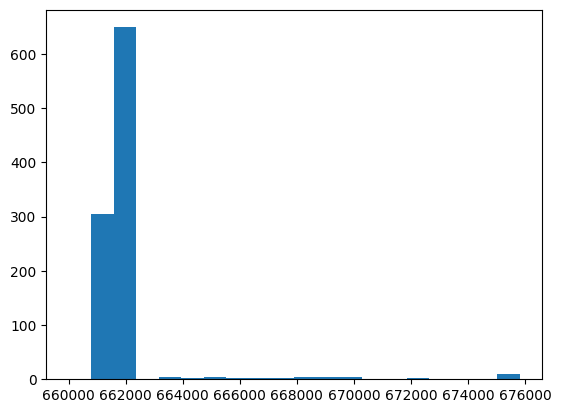

In [21]:
a = ((features).to_numpy()).reshape(-1,1)
plt.hist(a,bins=20)

#### Verificando o resultado para as features de 30 segundos:

In [18]:
nperseg=2048
def extract_features30s(n_mfcc=25):

    import os
    general_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
    os.chdir(general_path)

    def compute_features(y,sr, folder,file):
        
        _, _, spectrogram_data = spectrogram(x=y, fs=sr, nperseg=2048)
        spectrogram_data = np.abs(spectrogram_data)  # Take the absolute value of the spectrogram
        power_spectrum = np.mean(spectrogram_data, axis=1)
        normalized_spectrum = power_spectrum / np.sum(power_spectrum)
        frequency_axis = np.fft.rfftfreq(nperseg, 1 / sr)
        log_power_spectrum = np.log10(power_spectrum)
        energy = np.sum(spectrogram_data, axis=1)
        n_frames = energy.shape[0]
        
        spectral_entropy = entropy(normalized_spectrum, base=2)
        spread = np.sqrt(np.sum((frequency_axis[:, np.newaxis] - np.mean(frequency_axis)) ** 2 * power_spectrum[:, np.newaxis]) / np.sum(power_spectrum))
        skewness = skew(power_spectrum)
        slope, _, _, _, _ = linregress(frequency_axis, log_power_spectrum)
        decrease = np.zeros(n_frames)
        for i in range(1, n_frames):
            decrease[i] = np.sum(energy[i:] - energy[i - 1]) / (n_frames - i)
            
        peak_amplitude = np.max(np.abs(y))
        diff = np.diff(y)  # Compute the differences between consecutive samples
        mean_diff = np.mean(np.abs(diff))  # Calculate the mean absolute difference
        smoothness = mean_diff / peak_amplitude 
        
        
        features = []
        features = file
        features = np.append(features,len(y))
        features = np.append(features,np.mean(librosa.feature.chroma_stft(y=y,sr=sr)))
        features = np.append(features,np.var(librosa.feature.chroma_stft(y=y,sr=sr)))
        features = np.append(features, np.mean(librosa.feature.rms(y=y).flatten()))
        features = np.append(features, np.var(librosa.feature.rms(y=y).flatten()))
        features = np.append(features,librosa.feature.spectral_centroid(y=y,sr=sr).mean())
        features = np.append(features,librosa.feature.spectral_centroid(y=y,sr=sr).var())
        features = np.append(features,librosa.feature.spectral_bandwidth(y=y,sr=sr).mean())
        features = np.append(features,librosa.feature.spectral_bandwidth(y=y,sr=sr).var())
        features = np.append(features,librosa.feature.spectral_rolloff(y=y,sr=sr).mean())
        features = np.append(features,librosa.feature.zero_crossing_rate(y=y).mean())
        harmony, perceptual = librosa.effects.hpss(y=y)
        features = np.append(features,harmony.var())
        features = np.append(features,perceptual.mean()); features = np.append(features,perceptual.var())
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        features = np.append(features,np.mean(mfccs,axis=1).reshape(-1,1))
        features = np.append(features,np.var(mfccs,axis=1).reshape(-1,1))
        
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        features = np.append(features,np.mean(contrast));
        features = np.append(features,np.var(contrast)) #spectral contrast mean + var
        stft = librosa.stft(y=y);  magnitude = np.abs(stft); flux = librosa.onset.onset_strength(S=magnitude,sr=sr); 
        features = np.append(features, np.mean(flux)); features = np.append(features,np.var(flux)) #spectral flux mean + var
        crest = np.max(magnitude, axis=0) / (np.sum(magnitude, axis=0) + 1e-10)
        features = np.append(features, np.mean(crest)); 
        flatness = librosa.feature.spectral_flatness(y=y)
        features = np.append(features, np.var(flatness)) #spectral flatness mean + var
        features = np.append(features, np.mean(decrease)); 
        features = np.append(features, slope); #spectral slope 
        features = np.append(features, skewness); #spectral skewness
        features = np.append(features, spread); #spectral spread 
        features = np.append(features, spectral_entropy); #spectral entropy 
        features = np.append(features, smoothness); # peak smoothness
        
        features= np.append(features,folder)
    
        return features

    def read_file(file_path):
        y, sr = librosa.load(file_path)

        return y,sr

    path = np.sort(os.listdir());
    names=[]; labels = []

    test = np.empty((1,2*n_mfcc + 28 )); j=0
     # iterate through all file
    for folder in path:
        # Check whether file is in text format or not
        os.chdir(general_path+'/'+folder)
        for file in np.sort(os.listdir()):
            if file.endswith(".wav") and file != 'jazz.00054.wav':
                file_path = f"{general_path}/{folder}/{file}"
                
                y,sr = read_file(file_path)
                test = np.vstack((test,compute_features(y,sr,folder,file)))
    
                j=j+1
                
                print("file number: {}".format(j))
    
    print('Extraction complete, now saving into a DataFrame. ')
    
    columns = []
   
    columns = []
    columns.extend(['filename','length_30s'])
    columns.extend(['chroma_stft_mean_' , 'chroma_stft_var_' ,'rms_mean_' ,'rms_var_' , 
                  'spectral_centroid_mean_' , 'spectral_centroid_var_' , 
              'spectral_bandwidth_mean_' , 'spectral_bandwidth_var_' ,'rolloff_mean_' ,'zero_crossing_rate_mean_' ,
              'harmony_var_' , 'perceptr_mean_' ,'perceptr_var_' ])
    for j in range(n_mfcc):
        columns.append('mfcc' + str(j+1) + '_mean_')
        columns.append('mfcc' + str(j+1) + '_var_')
            
    columns.extend(['spectral_contrast_mean_', 'spectral_contrast_var_','spectral_flux_mean_',
                       'spectral_flux_var_','spectral_crest_mean_',
                    'spectral_flatness_var_','spectral_decrease_mean_', 'spectral_slope_',
                       'spectral_skewness_', 'spectral_spread_', 'spectral_entropy_','peak_smoothness_'])
        
    columns.append('label')
    
    features = pd.DataFrame(test, columns = columns)
    features = features.drop(index=0)
    features= features.reset_index()
    features = features.drop(columns='index')
      
    return features, test


In [19]:
features_30s_25MFCCs, t = extract_features30s()

file number: 1
file number: 2
file number: 3
file number: 4
file number: 5
file number: 6
file number: 7
file number: 8
file number: 9
file number: 10
file number: 11
file number: 12
file number: 13
file number: 14
file number: 15
file number: 16
file number: 17
file number: 18
file number: 19
file number: 20
file number: 21
file number: 22
file number: 23
file number: 24
file number: 25
file number: 26
file number: 27
file number: 28
file number: 29
file number: 30
file number: 31
file number: 32
file number: 33
file number: 34
file number: 35
file number: 36
file number: 37
file number: 38
file number: 39
file number: 40
file number: 41
file number: 42
file number: 43
file number: 44
file number: 45
file number: 46
file number: 47
file number: 48
file number: 49
file number: 50
file number: 51
file number: 52
file number: 53
file number: 54
file number: 55
file number: 56
file number: 57
file number: 58
file number: 59
file number: 60
file number: 61
file number: 62
file number: 63
f

In [20]:
features_30s_25MFCCs.to_csv('/kaggle/working/features_30s_extra_25mfccs.csv')

In [33]:
df = features_30s_25MFCCs.copy()
train_val, test = train_test_split(df, stratify=df['label'], test_size=1/5, random_state=0)
train, val = train_test_split(train_val, stratify=train_val['label'], test_size=1/4, random_state=0)

X_train_val = train_val.drop(columns=['label','filename','length_30s']); y_tv = train_val['label']
X_train = train.drop(columns=['label','filename','length_30s']); X_val = val.drop(columns=['label','filename','length_30s'])
y_train = train['label']; y_val = val['label']
X_test= test.drop(columns=['label','filename','length_30s']); y_test = test['label']
print((X_train.shape));
print((X_test.shape)); 
print((X_val.shape)); 
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(599, 75)
(200, 75)
(200, 75)
(599,)
(200,)
(200,)


In [34]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_tv_scaled = scaler.fit_transform(X_train_val)

In [37]:
param_grid = {'C':     10.0**np.arange(-3, 5.01, 1), 
              'gamma': 10.0**np.arange(-5, 3.01, 1)}
model = SVC(kernel='rbf', max_iter = 1000000,random_state=0);
gs_svm = grid_search(model, param_grid, X_train_scaled, y_train, X_val_scaled, y_val)
print('best_score:', gs_svm.best_score_)
print('best_params:', gs_svm.best_params_)

best_score: 0.75
best_params: {'C': 10.0, 'gamma': 0.01}


In [38]:
model = SVC(kernel='rbf', max_iter = 100000,random_state=4, C=10,gamma=0.01);
model.fit(X_train_scaled, y_train);
print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
model.fit(X_tv_scaled, y_tv);
print(f'Test refited accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}')
#pickle.dump(model, open('model_svmop.sav', 'wb'))

Test accuracy: 77.5%
Test refited accuracy: 80.5%


In [32]:
df

,filename,length_30s,chroma_stft_mean_,chroma_stft_var_,rms_mean_,rms_var_,spectral_centroid_mean_,spectral_centroid_var_,spectral_bandwidth_mean_,spectral_bandwidth_var_,...,spectral_flux_var_,spectral_crest_mean_,spectral_flatness_var_,spectral_decrease_mean_,spectral_slope_,spectral_skewness_,spectral_spread_,spectral_entropy_,peak_smoothness_,label
0,blues.00000.wav,661794,0.3501285,0.08877166,0.13018432,0.00282838,1784.1226409867395,129745.48453872248,2002.412407099093,85834.41036219463,...,0.05635866,0.041930255,3.0314568e-05,-0.0006218354204802997,-0.0005744706240715236,6.721633289370978,4953.474527878482,6.850236151002306,0.029599836,blues
1,blues.00001.wav,661794,0.3408494,0.09497618,0.09590782,0.00237272,1530.2617668815155,375915.50852199766,2038.9876081687958,213905.10295057268,...,0.02884359,0.06597747,2.3548295e-05,-0.00036945842536084016,-0.0005393035215199773,12.19750405303017,5129.697292408943,6.150783397873868,0.020975433,blues
2,blues.00002.wav,661794,0.36353773,0.08525664,0.17547321,0.002750858,1552.8324813719914,156471.01101167433,1747.7540869151062,76295.41345784656,...,0.09132686,0.04089263,1.1241475e-05,-0.001042160642162999,-0.0006298289141571816,5.785351226198573,4842.920331012963,7.053834716538527,0.041286346,blues
3,blues.00003.wav,661794,0.40485436,0.09399866,0.14104027,0.006347602,1070.153417999185,184366.0093845833,1596.4225646485252,166551.84432263998,...,0.028641738,0.101833,2.6640141e-06,-0.0008644808742089266,-0.0005756715214627686,21.47825045344102,5333.68054579769,4.021151469290355,0.012571546,blues
4,blues.00004.wav,661794,0.30852598,0.08784315,0.09150122,0.002305285,1835.1285128875488,343249.49574738194,1748.4107586184407,88378.7044917057,...,0.04872024,0.037442006,1.8973828e-05,-0.000312972027250948,-0.0006486046243292369,5.20646190913729,4444.690385155992,7.496465777133534,0.030674668,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,rock.00095.wav,661794,0.35197702,0.08047889,0.07944595,0.00034580583,2008.1745206409441,282095.5475196977,2106.3140916188945,88556.09069900782,...,0.013741459,0.04257852,6.033744e-05,-0.00020729604059371455,-0.0005231258455547256,14.546184026870817,4967.128097802147,6.386900443035228,0.030932635,rock
995,rock.00096.wav,661794,0.39886934,0.0751171,0.07642329,0.00058925396,2006.8272649211456,182135.8373563456,2068.8392593748954,82342.1774555408,...,0.013400852,0.03702526,3.360668e-05,-0.0001994797146541986,-0.0005510831023955132,10.974347166482445,4899.7231031583215,6.77838867877786,0.030448183,rock
996,rock.00097.wav,661794,0.43198025,0.075220674,0.08159775,0.0003222887,2077.5658220829505,231716.29082132122,1927.2280126977867,74753.37365424779,...,0.012464996,0.028341215,8.715015e-05,-0.00021012434381742292,-0.0005668421834317988,6.23502900185498,4692.532566609051,7.403970067846498,0.047496174,rock
997,rock.00098.wav,661794,0.3626352,0.09153154,0.083802395,0.0012068073,1398.649504763717,240406.20724054103,1818.1651247368884,109151.26387489072,...,0.007318795,0.07932983,8.4027715e-06,-0.000265757135445518,-0.0005706550532045423,10.717551641005024,5203.564387398929,5.478909438672487,0.022835553,rock
